# Preliminary Aeroelastic Optimization of the Simple Trasonic Wing with Nonlinear Structural Stability Constraints

* [Setup of the structural model](#structural-model)
    * [Structural mesh convergence study](#structural-mesh)
    * [Structural mesh verification](#structural-verification)
* [Setup of the aerodynamic model and of the aeroelastic coupling](#aerodynamic-model)
    * [Aerodynamic mesh convergence study](#aerodynamic-mesh)
* [Benchmark analyses](#benchmark)
    * [Aerodynamic analysis](#aerodynamic-analysis)
    * [Structural analysis](#structural-analysis)
    * [Aeroelastic analysis](#aeroelastic-analysis)
* [Optimizations](#optimizations)
    * [Linear buckling optimization](#linear-optimization)
    * [Nonlinear structural stability optimization](#nonlinear-optimization)

In [1]:
import matplotlib.pyplot as plt  # package for making plots
import tol_colors as tc  # package for colorblind-friendly colors
import os  # package for file and directory manipulation
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Set up matplotlib for interactive plotting
%matplotlib widget

# Set default color cycle to TOL bright and default dpi of figures
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))
plt.rcParams["figure.dpi"] = 120

# Set the path to the directory containing the analysis files
ANALYSIS_DIRECTORY_PATH = os.path.join(
    os.getcwd(), "analyses",                                   
    "Preliminary_Aeroelastic_Optimization_of_the_Simple_Trasonic_Wing_with_Nonlinear_Structural_Stability_Constraints")

# Set the environment variable for the directory containing the report files
report_directory_path = os.path.relpath(ANALYSIS_DIRECTORY_PATH, os.getcwd())
os.environ['OPENMDAO_REPORTS_DIR'] = report_directory_path

# Set the path to the directory containing the airfoil data
AIRFOIL_PATH = os.path.join(os.getcwd(), "resources", "STW", "rae2822.dat")

# Define constant variables related to plotting
Z_COMPONENT_INDEX = 2  # index of z-component in load and displacement array
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
UNSTABLE_COLOR = COLORS[1]  # color for unstable segments
GLASS_CEILING_COLOR = COLORS[2]  # green is used for glass ceiling
del COLORS[1:3]  # delete red from list of colors

# Define constant variables related to Nastran analysis
FIRST_SUBCASE_ID = 1
SECOND_SUBCASE_ID = 2
SPC_SET_ID = 1          # id of the SPC cards created by create_base_bdf
FORCE_SET_ID = 1        # id of the FORCE cards created by aeroelastic analysis
PRESSURE_SET_ID = 2     # id of the PLOAD2 cards used for benchmark structural analysis
GRAVITY_SET_ID = 3      # id of the GRAV card employed for benchmark structural analysis
LOAD_SET_ID = 4         # id of the LOAD card employed for SOL 105 and SOL 106
METHOD_SET_ID = 5       # id of method set used for the calculation of eigenvalues
TRIM_SET_ID = 6         # id of the TRIM card used for SOL 144
NO_EIGENVALUES = 20     # number of eigenvalues to be calculated
UPPER_EIGENVALUE = 1e5  # upper bound for the eigenvalues of the tangent stiffness matrix - set to 10^5 N/m to avoid convergence issues of Lanczos solver

# Define constant variables related to tolerances
OPTIMIZER_TOLERANCE = 1e-3  # convergence tolerance for the optimizer
NODE_TOLERANCE = 1e-4  # tolerance for node coordinates comparison [m]

## Setup of the structural model <a class="anchor" id="structural-model"></a>

***

In [2]:
from resources.STW import wingGeometry  # import the wing geometry module

# Create a base BDF object
target_length = .25  # [m]
stw_bdf, stw_layout = wingGeometry.create_base_bdf(target_length)
print(stw_bdf.get_bdf_stats())

pyGeo Initialization Type is: iges
Found 6 surfaces in Iges File.
Projecting Super Nodes...
Projecting All Nodes...
Setting up Ribs...
Setting up Spars...
Setting up Skins and Stringers...
Setting up Spar Bars
Setting up Rib Bars
Computing Topology and Numbering...
Unique Nodes: 7077
Total Nodes: 14550
Writing .bdf File...
---BDF Statistics---
SOL 103

bdf.spcs[1]: 142
  SPC:     142

bdf.params: 0
  PARAM    : 1

bdf.nodes: 7077
  GRID     : 7077

bdf.elements: 7480
  CQUAD4   : 7480

bdf.properties: 0
  PSHELL   : 1110

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Define function to apply uniform pressure load to lower skin.

In [3]:

import numpy as np
from itertools import compress

def apply_uniform_pressure_load(layout, bdf, set_id):
    # Find number of structural segments
    num_segments = len(layout.elemTopo.lIndex)
    
    # Initialize list of element ids for each segment and element counter
    elem_ids = [None] * num_segments
    elem = 1
    
    # Loop over all segments and find the element ids
    for i in range(num_segments):
        local = layout.elemTopo.lIndex[i]  # array with local node indices
        num_rows = local.shape[0] - 1  # number of element rows
        num_cols = local.shape[1] - 1  # number of element columns
        elem_ids[i] = np.arange(elem, elem + num_rows * num_cols)
        elem += num_rows * num_cols  # increment element counter
    
    # Find the element ids of the lower skin
    descriptions = np.array(layout.faceDescript)
    lower_skin_mask = np.char.find(descriptions, "L_SKIN") >= 0
    lower_skin_elem_ids = np.concatenate(
        list(compress(elem_ids, lower_skin_mask)))
    
    # Calculate surface area of the lower skin
    lower_skin_elem_areas = np.array(
        [bdf.elements[eid].Area() for eid in lower_skin_elem_ids])
    lower_skin_surface_area = np.sum(lower_skin_elem_areas)
    scale_factor = lower_skin_surface_area/len(lower_skin_elem_ids)
    
    # Apply the pressure load to each element of the lower skin
    for i, eid in enumerate(lower_skin_elem_ids):
        bdf.add_pload2(
            sid=set_id,
            pressure=-1/lower_skin_elem_areas[i]*scale_factor,
            eids=[eid])
    
def apply_benchmark_structural_analysis_load(
    layout, bdf, pressure_set_id, gravity_set_id, load_set_id, pressure_value):
    # Apply the pressure load to the lower skin
    apply_uniform_pressure_load(layout, bdf, pressure_set_id)
    
    # Apply the gravity load
    bdf.add_grav(sid=gravity_set_id, scale=9.81, N=np.array([0., 0., -1.]))
    
    # Combine the pressure and gravity loads with LOAD card
    bdf.add_load(
        sid=load_set_id, scale=1., scale_factors=[pressure_value, 2.5],
        load_ids=[pressure_set_id, gravity_set_id])

In [4]:
PRESSURE_LOAD = 30e3  # [Pa]

### Structural mesh convergence study <a class="anchor" id="structural-mesh"></a>

In [5]:
from resources import pynastran_utils, plot_utils

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
shell_element_target_lengths = np.geomspace(
    wingGeometry.rootLESparHeight/2, wingGeometry.stiffenerHeight/8, 10) # [m]
shell_element_target_lengths = np.array([shell_element_target_lengths[4]])
np.set_printoptions(precision=1, suppress=True)
print("Target length of shell elements for mesh convergence study [mm]:")
print(shell_element_target_lengths*1e3)

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_target_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_target_lengths), dtype=int)
buckling_load_factors = np.empty(np.shape(shell_element_target_lengths))

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 80  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(
            colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(
            colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Define amplification factor for displacements of buckling modes
amplification_factor = 1.5

# Iterate through the different edge lengths
for i, target_length in enumerate(shell_element_target_lengths):
    # Generate base bdf input
    sol_105_bdf, target_length_layout = wingGeometry.create_base_bdf(
        target_length=target_length, parallel=True)
    
    # Apply load
    apply_benchmark_structural_analysis_load(
        layout=target_length_layout, bdf=sol_105_bdf, pressure_set_id=PRESSURE_SET_ID,
        gravity_set_id=GRAVITY_SET_ID, load_set_id=LOAD_SET_ID,
        pressure_value=PRESSURE_LOAD)
    
    # Store number of elements and number of degrees of freedom of current model
    no_elements[i] = len(sol_105_bdf.elements)
    constrained_nodes_ids = next(iter(sol_105_bdf.spcs.values()))[0].node_ids
    dofs[i] = (len(sol_105_bdf.nodes) - len(constrained_nodes_ids))*6
    
    # Run SOL 105 and return OP2 object
    input_name = f"sol_105_{no_elements[i]}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105(
        bdf=sol_105_bdf, input_name=input_name, method_set_id=METHOD_SET_ID,
        analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
        static_load_set_id=LOAD_SET_ID, run_flag=False)
    
    # Find critical buckling load and print it
    print(f"""\n\033[1mResults of model with:
    - {target_length*1e3:.1f} mm prescribed element length
    - {no_elements[i]:d} elements
    - {dofs[i]:d} degrees of freedom\033[0m""")
    buckling_load_factors[i] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigr
    print(f"Buckling load factor: {buckling_load_factors[i]:.2f}")
    
    # Plot critical buckling mode
    # print("Buckling mode:")
    # _, ax, cbar = plot_utils.plot_eigenvector(
    #     op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
    #     displacement_component='tz', colormap='sunset',
    #     displacement_amplification_factor=amplification_factor)
    # adjust_3d_plot(ax, cbar)
    # plt.show()

Target length of shell elements for mesh convergence study [mm]:
[53.]
pyGeo Initialization Type is: iges
Found 6 surfaces in Iges File.
Projecting Super Nodes...
Projecting All Nodes...
Setting up Ribs...
Setting up Spars...
Setting up Skins and Stringers...
Setting up Spar Bars
Setting up Rib Bars
Computing Topology and Numbering...
Unique Nodes: 45483
Total Nodes: 65046
Writing .bdf File...


subcase=0 already exists...skipping


Nastran job sol_105_46432_elements.bdf completed
Wall time: 60.0 s

Results of model with:
    - 53.0 mm prescribed element length
    - 46432 elements
    - 272892 degrees of freedom
Buckling load factor: 0.48


Plot buckling load factor as a function of the number of degrees of freedom.

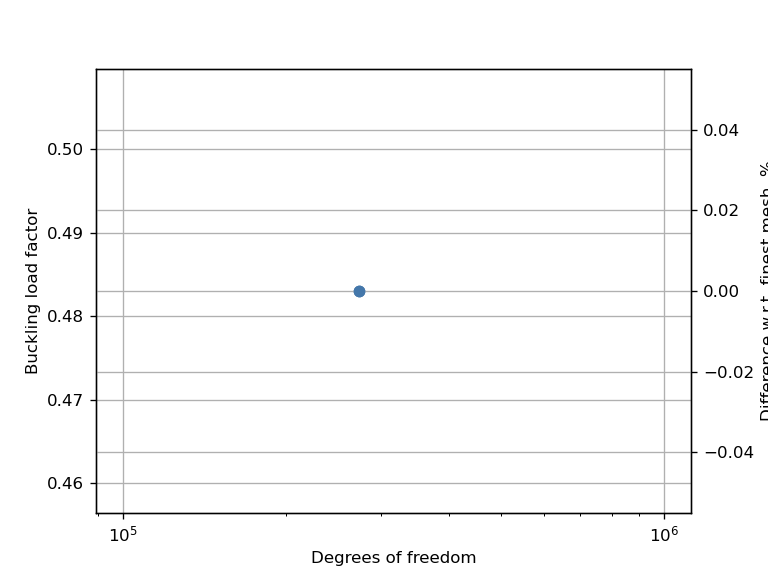

In [6]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, buckling_load_factors, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (buckling_load_factors/buckling_load_factors[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load factor')
ax2.set_ylabel('Difference w.r.t. finest mesh, %')
ax1.grid(True)
ax2.grid(True)
plt.show()

Convergence is defined as the point where the relative difference with the buckling load factor obtained from the finest mesh is less than 2.5%.

In [7]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 2.5)[0][0]  # find index corresponding to first percentage difference below 1
converged_target_struct_length = np.round(
    shell_element_target_lengths[converged_mesh_index], 4)  # store shell length of converged mesh
no_elements_converged_mesh = no_elements[converged_mesh_index]  # store number of elements of converged mesh
blf_converged_mesh = buckling_load_factors[converged_mesh_index]  # store buckling load of converged mesh approximating to the nearest integer
print(f"""
Converged structural mesh:
- target element length {converged_target_struct_length*1e3:.1f} mm
- {no_elements_converged_mesh} elements
- {dofs[converged_mesh_index]} degrees of freedom
- buckling load factor {blf_converged_mesh:.2f}""")


Converged structural mesh:
- target element length 53.0 mm
- 46432 elements
- 272892 degrees of freedom
- buckling load factor 0.48


### Structural mesh verification <a class="anchor" id="structural-verification"></a>

Run nonlinear analysis with original and refined meshes.

In [8]:
# Initialize dictionaries to store inputs and outputs of nonlinear analyses
bdf_dict = {}
layout_dict = {}
input_name_dict = {}
sol_106_op2_dict = {}

# Define shell elements' lengths to be used for the mesh verification study
mesh_labels = ["original mesh", "refined mesh"]
shell_element_target_lengths = np.array(
        [converged_target_struct_length, converged_target_struct_length/2])

# Iterate through the different edge lengths
for i, key in enumerate(mesh_labels):
        # Create mesh with converged target element length
        bdf_dict[key], layout_dict[key] = wingGeometry.create_base_bdf(
                target_length=shell_element_target_lengths[i], parallel=True)
        
        # Apply loads to the original mesh
        apply_benchmark_structural_analysis_load(
                layout_dict[key], bdf_dict[key], PRESSURE_SET_ID,
                GRAVITY_SET_ID, LOAD_SET_ID, PRESSURE_LOAD)
        pynastran_utils.create_static_load_subcase(
                bdf=bdf_dict[key], subcase_id=FIRST_SUBCASE_ID,
                load_set_id=LOAD_SET_ID)

        # Setup SOL 106 with arc-length method using parameters for fine
        # resolution of equilibrium path
        sol_106_bdf = bdf_dict[key].__deepcopy__({})
        pynastran_utils.set_up_arc_length_method(
                bdf=sol_106_bdf, max_iter=3, conv='PU', eps_u=5e-6, eps_p=5e-6,
                max_bisect=20, minalr=1e-5, desiter=4, maxinc=600)
        sol_106_bdf.case_control_deck.subcases[0].add_result_type(
                'NLSTRESS', 'ALL', ['PLOT'])
                
        # Run nonlinear analysis
        no_elements = len(sol_106_bdf.elements)
        input_name_dict[key] = f"sol_106_{no_elements}_elements"
        sol_106_op2_dict[key] =\
                pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
                        bdf=sol_106_bdf, method_set_id=METHOD_SET_ID,
                        analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                        input_name=input_name_dict[key],
                        no_eigenvalues=NO_EIGENVALUES,
                        upper_eig=UPPER_EIGENVALUE, run_flag=False)

pyGeo Initialization Type is: iges
Found 6 surfaces in Iges File.
Projecting Super Nodes...
Projecting All Nodes...
Setting up Ribs...
Setting up Spars...
Setting up Skins and Stringers...
Setting up Spar Bars
Setting up Rib Bars
Computing Topology and Numbering...
Unique Nodes: 45483
Total Nodes: 65046
Writing .bdf File...


subcase=0 already exists...skipping


Nastran job sol_106_46432_elements.bdf completed
Wall time: 101457.0 s
pyGeo Initialization Type is: iges
Found 6 surfaces in Iges File.
Projecting Super Nodes...
Projecting All Nodes...
Setting up Ribs...
Setting up Spars...
Setting up Skins and Stringers...
Setting up Spar Bars
Setting up Rib Bars
Computing Topology and Numbering...
Unique Nodes: 119761
Total Nodes: 153174
Writing .bdf File...


subcase=0 already exists...skipping


Nastran job sol_106_121256_elements.bdf completed
Wall time: 350015.0 s


Plot eigenvalue diagrams.

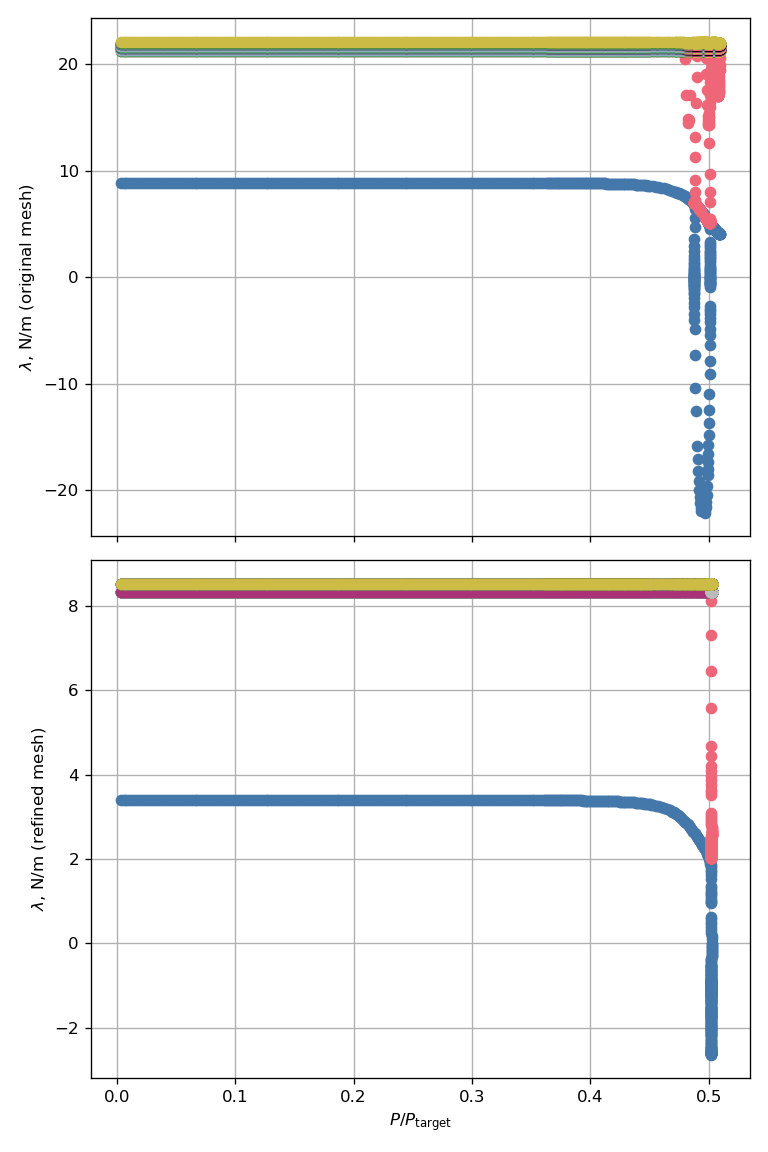

In [9]:
# Initialize dictionaries to store nondimensional applied loads and eigenvalues of tangent stiffness matrix
nondimensional_loads_dict = {}
eigenvalues_dict = {}

# Loop over the two models and read applied loads and eigenvalues
for key in sol_106_op2_dict:
    load_factors, _, _ =\
        pynastran_utils.read_load_displacement_history_from_op2(
            op2=sol_106_op2_dict[key])  # read applied loads from OP2 object
    nondimensional_loads_dict[key] = load_factors[FIRST_SUBCASE_ID]
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name_dict[key] + '.f06')  # path of f06 file
    eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)  # read eigenvalues from f06 file

# Plot the eigenvalue diagram for both models
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8*2))  # create a figure with two axes
for i, key in enumerate(input_name_dict):  # iterate over the two models
    plot_utils.plot_eigenvalue_diagram(
        loads=nondimensional_loads_dict[key],
        eigenvalues=eigenvalues_dict[key],
        axes=axes[i])  # convert eigenvalues from N/mm to N/m
    axes[i].set_ylabel(f"$\lambda$, N/m ({key})")  # set y-axis label

# Finalize plot appearance
axes[i].set_xlabel("$P/P_\mathrm{target}$")
plt.tight_layout()
plt.show()

We want to compare the load-displacement diagram now in terms of the tip displacement and of the displacement at the node experiencing the largest displacement in the critical buckling mode.

For both meshes, we find the ids of the nodes at the intersection between top skin, spars and tip rib. We will use these nodes to calculate the tip displacement and the twist according to the specifications of the Benchmark Problems document.

In [10]:
def find_intersection_nodes(layout, part_names):
    # Store face descriptions in a numpy array
    descriptions = np.array(layout.faceDescript)
    
    # Find the nodes' ids of each part
    part_nodes_ids = [np.array([])]*len(part_names)
    for i, name in enumerate(part_names):
        mask = np.char.find(descriptions, name) >= 0
        nodes_lindex = list(compress(layout.elemTopo.lIndex, mask))
        part_nodes_ids[i] = np.unique(
            np.concatenate([arr.flatten() for arr in nodes_lindex]) + 1)

    # Find the intersection nodes' ids
    intersection_nodes_ids = part_nodes_ids[0]
    for i in range(1, len(part_names)):
        intersection_nodes_ids = np.intersect1d(
            intersection_nodes_ids, part_nodes_ids[i], assume_unique=True)
        
    # Return the intersection nodes' ids
    return intersection_nodes_ids

def find_tip_nodes(layout, bdf):
    # Find the ids of the intersection nodes between the upper skin, rib and spar
    intersection_nodes_ids = find_intersection_nodes(
        layout, ["U_SKIN", "RIB", "SPAR"])

    # Create a (N,3) array of coordinates for the intersection nodes
    intersection_nodes_xyz_array = np.vstack(
        [bdf.nodes[node_id].xyz for node_id in intersection_nodes_ids])
    
    # Mask to find the nodes on the tip rib
    tip_nodes_mask = np.abs(
        intersection_nodes_xyz_array[:, 1] - layout.X[-1, 0, 1]
        ) < NODE_TOLERANCE
    
    # Return the ids and coordinates of the tip nodes
    return intersection_nodes_ids[tip_nodes_mask],\
        intersection_nodes_xyz_array[tip_nodes_mask]

# Initialize dictionaries to store tip nodes' ids and coordinates
tip_nodes_ids_dict = {}
tip_nodes_coords_dict = {}

# Find the tip nodes of the original mesh
for key in mesh_labels:
    tip_nodes_ids_dict[key], tip_nodes_coords_dict[key] = find_tip_nodes(
        layout_dict[key], bdf_dict[key])


We find the largest displacement node for critical buckling mode of model with original mesh.

Critical buckling mode of original mesh:


/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


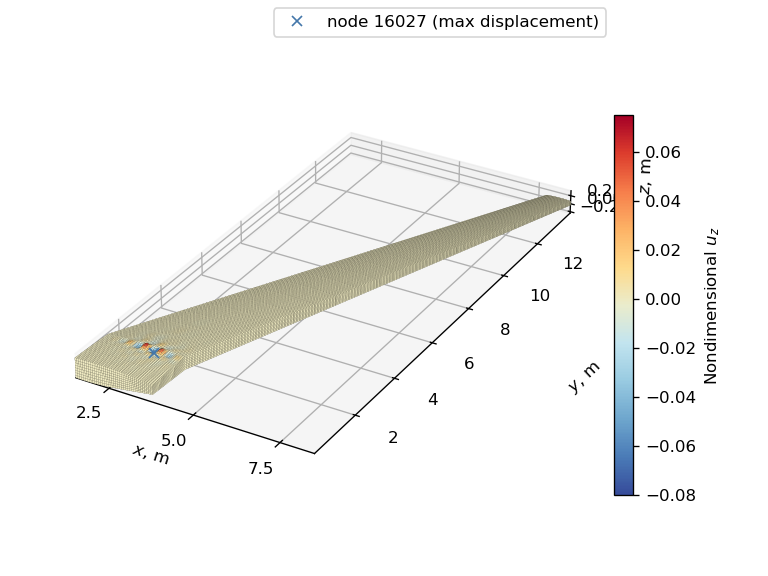

In [11]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Read op2 file of SOL 105 analysis with original mesh
input_name = f"sol_105_{no_elements_converged_mesh}_elements"
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(
    op2_filename=op2_filepath, load_geometry=True, debug=None)

# Plot critical buckling mode
key = "original mesh"
print(f"Critical buckling mode of {key}:")
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz',
    colormap='sunset', displacement_amplification_factor=amplification_factor)
    
# Plot node where max displacement occurs and add node id to dictionary
max_disp_node_id_dict = {key: plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2,
    displacement_amplification_factor=amplification_factor)}

# Add legend, adjust plot appearance and show plot
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

We run a linear buckling analysis for the model with the refined mesh and find the largest displacement node for the critical buckling mode.

Nastran job sol_105_121256_elements.bdf completed
Wall time: 73.0 s
Critical buckling mode of refined mesh:


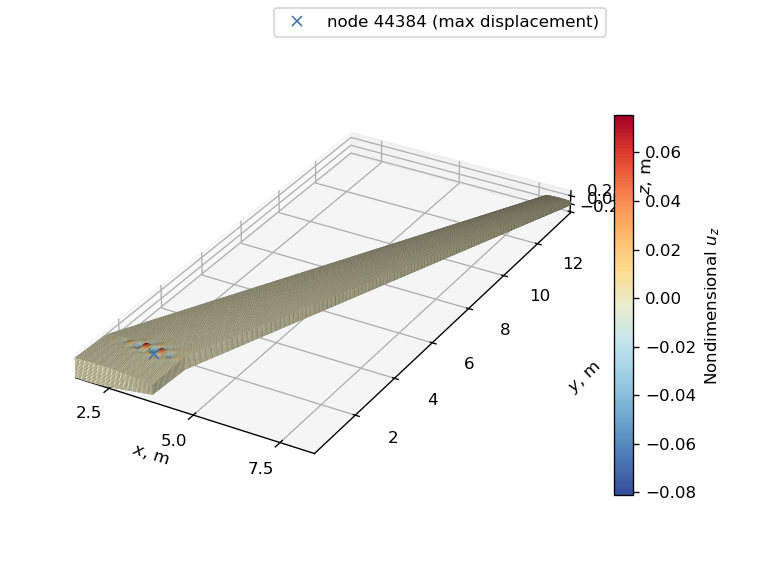

In [12]:
# Run SOL 105 for model with refined mesh
key = "refined mesh"
input_name = f"sol_105_{no_elements}_elements"
sol_105_op2 = pynastran_utils.run_sol_105(
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
    bdf=bdf_dict[key], method_set_id=METHOD_SET_ID, run_flag=False)

# Plot critical buckling mode
print(f"Critical buckling mode of {key}:")
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz',
    colormap='sunset', displacement_amplification_factor=amplification_factor)
    
# Plot node where max displacement occurs and add node id to dictionary
max_disp_node_id_dict[key] = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2,
    displacement_amplification_factor=amplification_factor)

# Add legend, adjust plot appearance and show plot
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

Read displacement histories from op2 files and plot them.

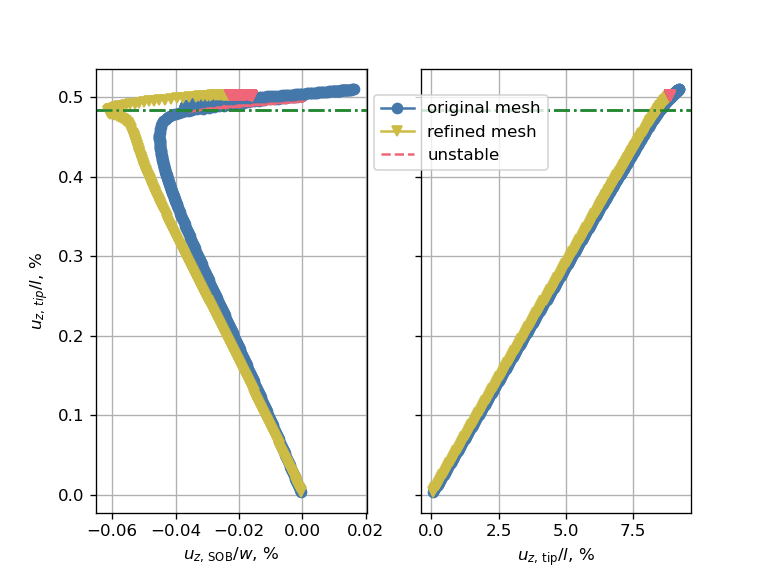

In [13]:
def calculate_tip_deflection(node_1_displacements, node_2_displacements):
    delta_z_tip = .5*(
        node_1_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] +\
        node_2_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX])
    return delta_z_tip
    
# Create 3D plot of load-displacement diagram
fig, axes = plt.subplots(1, 2, sharey=True)  # create a figure with two subplots
displacement_labels = ["SOB", "tip"]  # labels for the displacements
reference_lengths = [wingGeometry.meanAerodynamicChord, wingGeometry.semiSpan]  # reference lengths for the displacements
reference_lengths_labels = ["w", "l"]  # labels for the reference lengths
stable_lines = []  # list to store proxy artists for the legend

# Loop over the two meshes and plot the load-displacement diagram
for i, key in enumerate(mesh_labels):
    # Read the displacement history
    _, _, displacements =\
        pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2_dict[key],
        node_ids=[max_disp_node_id_dict[key]] + list(tip_nodes_ids_dict[key]))
        
    # Calculate nondimensional SOB displacements
    nondimensional_sob_displacements = displacements[
        max_disp_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/\
            wingGeometry.meanAerodynamicChord
    
    # Calculate nondimensional tip displacements
    nondimensional_tip_displacements = calculate_tip_deflection(
        displacements[tip_nodes_ids_dict[key][0]],
        displacements[tip_nodes_ids_dict[key][1]])/wingGeometry.semiSpan
    
    # Store nondimensional displacements in a list
    displacement_list = [
        nondimensional_sob_displacements, nondimensional_tip_displacements]
    
    # Loop over the two displacements and plot the load-displacement diagram
    for j, displacements in enumerate(displacement_list):
        plot_utils.plot_2d_load_displacements_stability(
            axes=axes[j],
            displacements=displacements*100,
            loads=nondimensional_loads_dict[key],
            eigenvalues=eigenvalues_dict[key],
            marker=MARKERS[i], color=COLORS[i])
        # Plot glass-ceiling line
        axes[j].axhline(
            y=blf_converged_mesh, color=GLASS_CEILING_COLOR, linestyle='-.')
        # Set grid and x-axis label
        axes[j].grid(visible=True)
        axes[j].set_xlabel(
            f"$u_{{z,\,\mathrm{{{displacement_labels[j]}}}}}/{reference_lengths_labels[j]}$, %")
    
    # Add proxy artist for the legend
    stable_lines.append(Line2D(
        [0], [0], linestyle='-', marker=MARKERS[i], color=COLORS[i],
        label=key))

# Add proxy artist for unstable lines and create legend
unstable_line = Line2D(
    [0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
linear_buckling_line = Line2D(
    [0], [0], linestyle='-.', color=GLASS_CEILING_COLOR,
    label="linear buckling load")
fig.legend(
    handles=stable_lines + [unstable_line],
    loc="upper center", bbox_to_anchor=(0.6, 0.85))

# Set plot appearance
axes[0].set_ylabel("$u_{z,\,tip}/l$, %")

plt.show()

## Setup of the aerodynamic model and of the aeroelastic coupling <a class="anchor" id="aerodynamic-model"></a>

***

Define functions to set up SOL 144 and the aerodynamic model.

In [14]:
from ambiance import Atmosphere  # class for stabdard atmosphere calculations
from scipy.interpolate import interp1d

def mach_altitude_to_dynamic_pressure(mach, altitude):
    # Find air density and speed of sound
    rho_air = Atmosphere(altitude).density[0]  # air density
    speed_of_sound = Atmosphere(altitude).speed_of_sound[0]  # speed of sound
    # Calculate air speed
    air_speed = mach*speed_of_sound
    # Calculate dynamic pressure
    return 0.5*rho_air*air_speed**2

# Define function for general setup of SOL 144
def set_up_sol_144(
    bdf, trim_id, mach, angle_of_attack, altitude, reference_chord,
    reference_span, reference_surfacea_area):
    # Define solution sequence
    bdf.sol = 144
    
    # Find dynamic pressure based on mach number and altitude
    q = mach_altitude_to_dynamic_pressure(mach, altitude)
    
    # Define labels for static aeroelastic inputs
    aestat_labels = ["ANGLEA", "PITCH", "URDD3", "URDD5"]
    for i, label in enumerate(aestat_labels):
        bdf.add_aestat(aestat_id=i+1, label=label)
    
    # Add trim card with the defined static aeroelastic inputs
    # - angle of attack = angle_of_attack
    # - pitch rate = 0
    # - vertical acceleration = 0
    # - pitch acceleration = 0
    bdf.add_trim(
        sid=trim_id, mach=mach, q=q, labels=aestat_labels,
        uxs=[np.deg2rad(angle_of_attack), 0., 0., 0.])

    # Create first subcase and assign trim id
    bdf.create_subcases(subcase_ids=1)
    bdf.case_control_deck.subcases[1].add_integer_type('TRIM', trim_id)

    # Define basic parameters for static aeroelasticity
    # - reference chord
    # - reference span
    # - reference area
    # - aerodynamic loading symmetry --> symmetry about the xz-plane
    bdf.add_aeros(
        cref=reference_chord, bref=reference_span,
        sref=reference_surfacea_area, sym_xz=1)
    
def calculate_camber_line_slopes(airfoil_filepath, nchord):
    # Read the data, skipping the first line (header)
    data = np.loadtxt(airfoil_filepath, skiprows=1)
    
    # Separate x and y coordinates
    x, y = data[:, 0], data[:, 1]
    
    # Find the point where the profile wraps around (trailing edge to leading edge)
    # This is typically where x starts increasing again
    dx = np.diff(x)
    wrap_idx = np.where(dx > 0)[0][0]
    
    # Separate upper and lower surfaces
    x_upper = x[:wrap_idx+1]
    y_upper = y[:wrap_idx+1]
    x_lower = x[wrap_idx:]
    y_lower = y[wrap_idx:]
    
    # Create interpolation functions for upper and lower surfaces
    # Use cubic interpolation for smoothness
    f_upper = interp1d(x_upper, y_upper, kind='cubic')
    f_lower = interp1d(x_lower, y_lower, kind='cubic')
    
    # Create x points for camber line
    # Use the overlapping x-range between upper and lower surfaces
    x_camber = np.unique(np.concatenate((x_upper, x_lower)))
    
    # Calculate camber line (mean line between upper and lower surfaces)
    y_camber = (f_upper(x_camber) + f_lower(x_camber)) / 2
    
    # Create interpolation function for camber line
    f_camber = interp1d(x_camber, y_camber, kind='cubic')
    
    # Calculate segment size
    segment_length = 1.0 / nchord
    
    # Calculate three-quarter points for each segment
    x_positions = np.array([
        i * segment_length + 0.75 * segment_length for i in range(nchord)])
    
    # Small delta for numerical differentiation
    dx = 1e-6
    
    # Calculate slopes using central difference
    slopes = np.zeros(nchord)
    for i, x in enumerate(x_positions):
        # Ensure we don't go outside the interpolation range
        if x + dx > 1.0:
            # Use backward difference at the end
            dy = f_camber(x) - f_camber(x - dx)
        elif x - dx < 0.0:
            # Use forward difference at the start
            dy = f_camber(x + dx) - f_camber(x)
        else:
            # Use central difference
            dy = f_camber(x + dx/2) - f_camber(x - dx/2)
        # Calculate slope in radians
        slopes[i] = np.arctan2(dy, dx)
    
    return slopes
    
def define_aerodynamic_model(
    bdf, paero_id, caero_ids, p1_xyz_array, p4_xyz_array, chord_array,
    target_length, airfoil_filepath):
    # Add PAERO1 card - dummy property for associated bodies for the panels in
    # the Doublet-Lattice method
    bdf.add_paero1(pid=paero_id)
    
    # Loop over the aerodynamic macro elements to define them
    for i, eid in enumerate(caero_ids):
        # Find number of spanwise and chordwise divisions
        nchord = round(np.mean(chord_array[i])/target_length)
        nspan = round(
            np.linalg.norm(p4_xyz_array[i] - p1_xyz_array[i])/target_length)
        # Define aerodynamic macro element
        bdf.add_caero1(
            eid=eid, pid=paero_id, igroup=1, p1=p1_xyz_array[i],
            x12=chord_array[i, 0], p4=p4_xyz_array[i], x43=chord_array[i, 1],
            nspan=nspan, nchord=nchord)
        # Add W2GJ corrections for airfoil camber
        box_id_component_list = [
            (id, 3) for id in range(eid, eid + nspan*nchord)]
        slopes = calculate_camber_line_slopes(airfoil_filepath, nchord)
        correction_vector = np.tile(-slopes, nspan)  # minus sign for Nastran convention
        bdf.add_dmij(
            name='W2GJ', form=9, tin=1, tout=2, nrows=None, ncols=1,
            GCj=[(1, 1)]*nspan*nchord, GCi=box_id_component_list,
            Real=correction_vector)

Define functions to set up load reference axis and to couple the aerodynamic and structural models with a surface spline.

In [15]:
def define_load_reference_axis(
    bdf, intersection_nodes_ids, le_xzy_array, te_xyz_array):
    # Find last node id and intialize array of spline nodes ids
    last_node_id = len(bdf.nodes)
    spline_nodes_ids = np.arange(
        last_node_id + 1, last_node_id +1 + 3*len(le_xzy_array))
    
    # Create a (N,3) array of coordinates for the intersection nodes
    intersection_nodes_xyz_array = np.vstack(
        [bdf.nodes[node_id].xyz for node_id in intersection_nodes_ids])
    
    # Loop over the y-coordinates of the ribs
    te_node_id = last_node_id  # initialize trailing edge node id
    for (le_xyz, te_xyz) in zip(le_xzy_array, te_xyz_array):
        # Add node at quarter chord
        c_4_node_id = te_node_id + 1
        c_4_xyz = le_xyz + (te_xyz - le_xyz)/4
        bdf.add_grid(c_4_node_id, c_4_xyz)
        
        # Find id of the skin nodes intersecting current rib
        connection_nodes_ids = intersection_nodes_ids[
            np.abs(intersection_nodes_xyz_array[:, 1] - c_4_xyz[1]) <\
                NODE_TOLERANCE]
        
        # Add RBE3 element to connect quarter chord node with skin nodes
        rbe3_eid = len(bdf.elements) + len(bdf.rigid_elements) + 1
        bdf.add_rbe3(
            eid=rbe3_eid, refgrid=c_4_node_id, refc='123456', weights=[1.],
            comps=['123456'], Gijs=[connection_nodes_ids.tolist()])
        
        # Add nodes at wing leading and trailing edge
        le_node_id = c_4_node_id + 1
        bdf.add_grid(le_node_id, le_xyz)
        te_node_id = le_node_id + 1
        bdf.add_grid(te_node_id, te_xyz)
        
        # Add RBE2 element to connect leading and trailing edge node with
        # quarter chord node
        rbe2_eid = len(bdf.elements) + len(bdf.rigid_elements) + 1
        bdf.add_rbe2(rbe2_eid, c_4_node_id, '123456', [le_node_id, te_node_id])
        
    # Return spline nodes ids
    return spline_nodes_ids

# Function to define surface spline data
def define_surface_spline(
    bdf, set1_id, spline_nodes_ids, caero_ids, usage="BOTH"):
    # Add SET1 card to the BDF file to define the set of nodes for spline
    # interpolation
    bdf.add_set1(sid=set1_id, ids=spline_nodes_ids)
    
    # Add SPLINE1 card for each aerodynamic macro element
    spline1_eid = len(bdf.elements) + len(bdf.rigid_elements)
    for eid in caero_ids:
        spline1_eid += 1
        box2 = eid + bdf.caeros[eid].nspan*bdf.caeros[eid].nchord - 1
        bdf.add_spline1(
            eid=spline1_eid, caero=eid, box1=eid, box2=box2, setg=set1_id,
            usage=usage)

### Aerodynamic mesh convergence study <a class="anchor" id = "aerodynamic-mesh"></a>

Define flight conditions and set up SOL 144.

In [16]:
# Define flight conditions for aerodynamic mesh convergence study
cruise_altitude = 10400  # [m]
cruise_mach = 0.77
mesh_convergence_study_aoa = 5  # [deg]

# Define id of aeroelastic analysis cards and set up SOL 144
sol_144_bdf = stw_bdf.__deepcopy__({})
set_up_sol_144(
        sol_144_bdf, TRIM_SET_ID, cruise_mach, mesh_convergence_study_aoa,
        cruise_altitude, wingGeometry.meanAerodynamicChord,
        wingGeometry.semiSpan*2, wingGeometry.planformArea)

Define variables for the set up of the aerodynamic model.

In [17]:
paero_id = np.max(
        np.fromiter(stw_bdf.properties.keys(), dtype=int)) + 1
caero_id = int(10**np.ceil(
    np.log10(np.max(np.fromiter(stw_bdf.elements.keys(), dtype=int))))) + 1
p1_xyz_array = np.atleast_2d(wingGeometry.LECoords[0, :])
p4_xyz_array = np.atleast_2d(wingGeometry.LECoords[-1, :])
chord_array = np.atleast_2d(wingGeometry.sectionChord)
set1_sid = TRIM_SET_ID + 1

Define variables for the set up of the load reference axis.

In [18]:
# Find nodes at the intersection between skin and ribs
intersection_nodes_ids = find_intersection_nodes(
    stw_layout, ["RIB", "SKIN"])

# Find ribs' y-coordinates
ribs_y_coords = stw_layout.X[:, 0, 1]

# Find leading edge coordinates corresponding to ribs' y-coordinates
interp_coords = lambda coords, y: coords[0] + np.outer(
    y - coords[0,1], (coords[1] - coords[0])) / (coords[1,1] - coords[0,1])
le_xyz_array = interp_coords(wingGeometry.LECoords, ribs_y_coords)
te_xyz_array = interp_coords(wingGeometry.TECoords, ribs_y_coords)

Define function to read the aerodynamic results.

In [19]:
# Define name of monitor point and of component for monitor point definition
monpnt1_name = "C/4"
aecomp_name = "WING"

Run aerodynamic mesh convergence study.

In [20]:
# Define target lattice lengths and initialize arrays to store results
lattice_lengths = np.geomspace(
    wingGeometry.meanAerodynamicChord/4,
    wingGeometry.meanAerodynamicChord/32, 10) # [m]
grid_factors = np.empty_like(lattice_lengths)
normal_force_array = np.empty_like(lattice_lengths)
moment_array = np.empty_like(lattice_lengths)

# Run analysis for each lattice length
for i, target_length in enumerate(lattice_lengths):
    # Define aerodynamic model
    target_length_bdf = sol_144_bdf.__deepcopy__({})
    define_aerodynamic_model(
        target_length_bdf, paero_id, [caero_id], p1_xyz_array, p4_xyz_array,
        chord_array, target_length, AIRFOIL_PATH)
    
    # Define load reference axis and surface spline
    spline_nodes_ids = define_load_reference_axis(
        target_length_bdf, intersection_nodes_ids, le_xyz_array, te_xyz_array)
    define_surface_spline(
        target_length_bdf, set1_sid, spline_nodes_ids, [caero_id],
        usage="FORCE")
    
    # Find number of chordwise and spanwise elements and store grid factor
    no_elements = target_length_bdf.caeros[caero_id].nspan*\
        target_length_bdf.caeros[caero_id].nchord
    grid_factors[i] = no_elements**(-2/3)
    
    # Define monitor point after deepcopy to avoid pynastran bug raising an
    # error when deepcopying monitor points
    c_4_xyz = le_xyz_array[0] + (te_xyz_array[0] - le_xyz_array[0])/4
    target_length_bdf.add_aecomp(
        name=aecomp_name, list_type="CAERO", lists=caero_id)
    target_length_bdf.add_monpnt1(
        name=monpnt1_name,
        label="Integrated aerodynamic forces and moments about c/4", axes='35',
        aecomp_name=aecomp_name, xyz=c_4_xyz)
    
    # Run analysis
    print(f"Running analysis with target lattice length {target_length}")
    input_name = f"sol_144_{no_elements}_aero_elements"
    pynastran_utils.run_analysis(
        directory_path=ANALYSIS_DIRECTORY_PATH, bdf=target_length_bdf,
        filename=input_name, run_flag=False)
    
    # Read monitor point data and store normal force and moment
    aerodynamic_loads = pynastran_utils.read_monitor_point_from_f06(
        f06_path=os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06'),
        monitor_point_name=monpnt1_name)
    normal_force_array[i] = aerodynamic_loads['CZ'][0]
    moment_array[i] = aerodynamic_loads['CMY'][0]

Running analysis with target lattice length 0.8910256410256411
Running analysis with target lattice length 0.707207519947371
Running analysis with target lattice length 0.561310980562139
Running analysis with target lattice length 0.44551282051282054
Running analysis with target lattice length 0.3536037599736855
Running analysis with target lattice length 0.28065549028106945
Running analysis with target lattice length 0.22275641025641024
Running analysis with target lattice length 0.17680187998684274
Running analysis with target lattice length 0.14032774514053475
Running analysis with target lattice length 0.11137820512820513


Plot the results of the mesh convergence study in terms of normal force and moment about the root quarter chord point as a function of the grid factor.

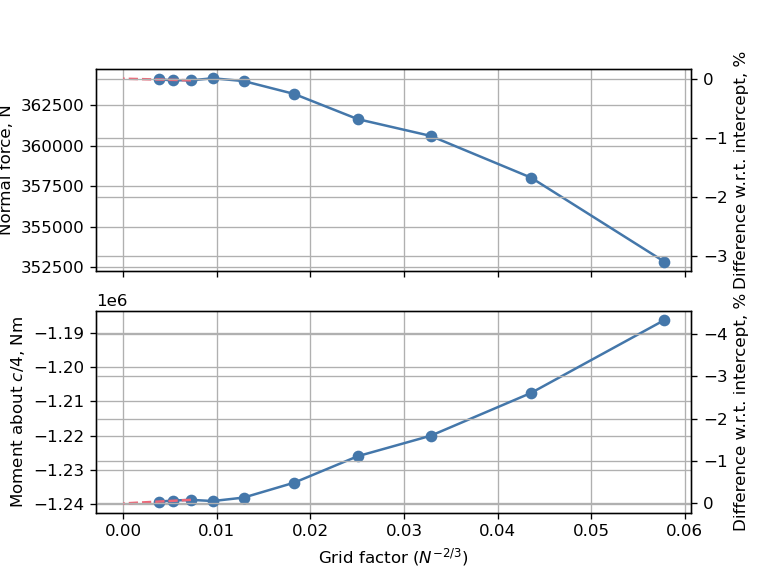

In [21]:
from scipy.stats import linregress

# Create figure with two subplots
fig, axes = plt.subplots(2, 1, sharex=True)

# Plot normal force vs grid factor
axes[0].plot(grid_factors, normal_force_array, 'o-')
axes[0].set_ylabel('Normal force, N')
axes[0].grid(True)

# Plot moment about c/4 vs grid factor
axes[1].plot(grid_factors, moment_array, 'o-')
axes[1].set_ylabel('Moment about $c/4$, Nm')
axes[1].grid(True)
axes[1].set_xlabel('Grid factor ($N^{-2/3}$)')

# Extract the last three points of both plots to calculate the Richardson extrapolation
last_three_gf = grid_factors[-3:]
last_three_normal_forces = normal_force_array[-3:]
last_three_moments = moment_array[-3:]

# Perform linear regression for normal force and moment and calculate intercepts of Richardson extrapolation lines
_, intercept_normal_force, _, _, _ = linregress(
    last_three_gf, last_three_normal_forces)
_, intercept_moment, _, _, _ = linregress(last_three_gf, last_three_moments)

# Plot Richardson extrapolation lines
axes[0].plot(
    [grid_factors[-3], 0],
    [last_three_normal_forces[-3], intercept_normal_force],
    '--')
axes[1].plot(
    [grid_factors[-3], 0],
    [last_three_moments[-3], intercept_moment],
    '--')

# Create a twin set of axes to plot percentage difference w.r.t. Richardson extrapolation lines intercepts
twin_scale = lambda y, y0: (y/y0 - 1)*100  # function to calculate percentage difference
intercepts_list = [intercept_normal_force, intercept_moment]  # list of intercepts
for i, intercept in enumerate(intercepts_list):  # loop over subplots
    twin_ax = axes[i].twinx()  # create twin axes
    ymin, ymax = axes[i].get_ylim()  # get y-axis limits of main axes
    twin_ax.set_ylim(twin_scale(ymin, intercept), twin_scale(ymax, intercept))  # set y-axis limits of twin axes to match percentage differences
    twin_ax.plot([], [])  # add empty plot to twin axes to ensure correct scaling
    twin_ax.set_ylabel('Difference w.r.t. intercept, %')  # set y-axis label of twin axes
    twin_ax.grid(True)  # enable grid for twin axes

# Show plot
plt.show()

In [22]:
# Find index where percentage difference is below 1% for both normal force and
# moment
normal_force_percentage_diff = twin_scale(
    normal_force_array, intercept_normal_force)  # calculate percentage differences for normal forces
moment_percentage_diff = twin_scale(
    moment_array, intercept_moment)  # calculate percentage differences for moments
converged_mesh_index = np.where(
    (np.abs(normal_force_percentage_diff) < 1) & 
    (np.abs(moment_percentage_diff) < 1))[0][0]

# Print results of the mesh convergence study
converged_target_aero_length = lattice_lengths[converged_mesh_index]
nchord_converged_mesh = round(
    wingGeometry.meanAerodynamicChord/converged_target_aero_length)
nspan_converged_mesh = round(
    wingGeometry.semiSpan/converged_target_aero_length)
print(f"""Converged aerodynamic mesh:
- target lattice length {converged_target_aero_length*1e3:.1f} mm
- {nchord_converged_mesh} elements in the chordwise direction
- {nspan_converged_mesh} elements in the spanwise direction""")

Converged aerodynamic mesh:
- target lattice length 353.6 mm
- 10 elements in the chordwise direction
- 40 elements in the spanwise direction


## Benchmark analyses <a class="anchor" id = "benchmark"></a>

***

### Aerodynamic analysis <a class="anchor" id = "aerodynamic-analysis"></a>

Define angles of attack of the benchmark aerodynamic analyses.

In [23]:
benchmark_aerodynamic_aoa = np.arange(0., 6.)  # angles of attack [deg]
lift_coefficient_array = np.empty_like(benchmark_aerodynamic_aoa)

Run the benchmark aerodynamic analyses.

In [24]:
# Define aerodynamic model
sol_144_bdf = stw_bdf.__deepcopy__({})
define_aerodynamic_model(
    sol_144_bdf, paero_id, [caero_id], p1_xyz_array, p4_xyz_array,
    chord_array, converged_target_aero_length, AIRFOIL_PATH)
    
# Define load reference axis and surface spline
spline_nodes_ids = define_load_reference_axis(
    sol_144_bdf, intersection_nodes_ids, le_xyz_array, te_xyz_array)
define_surface_spline(
    sol_144_bdf, set1_sid, spline_nodes_ids, [caero_id], usage="FORCE")

# Find dynamic pressure at cruise conditions
cruise_dynamic_pressure = mach_altitude_to_dynamic_pressure(
        cruise_mach, cruise_altitude)

# Loop over angles of attack
for i, aoa in enumerate(benchmark_aerodynamic_aoa):
    # Set up SOL 144 with the current angle of attack
    aoa_bdf = sol_144_bdf.__deepcopy__({})
    set_up_sol_144(
            aoa_bdf, TRIM_SET_ID, cruise_mach, aoa, cruise_altitude,
            wingGeometry.meanAerodynamicChord, wingGeometry.semiSpan*2,
            wingGeometry.planformArea)
    
    # Define monitor point after deepcopy to avoid pynastran bug raising an
    # error when deepcopying monitor points
    aoa_bdf.add_aecomp(name=aecomp_name, list_type="CAERO", lists=caero_id)
    aoa_bdf.add_monpnt1(
        name=monpnt1_name,
        label="Integrated aerodynamic forces and moments about c/4", axes='35',
        aecomp_name=aecomp_name, xyz=c_4_xyz)
    
    # Run analysis
    print(f"Running analysis with angle of attack {aoa:.1f} deg")
    input_name = f"sol_144_benchmark_aerodynamic_{aoa:.0f}deg"
    pynastran_utils.run_analysis(
        directory_path=ANALYSIS_DIRECTORY_PATH, bdf=aoa_bdf,
        filename=input_name, run_flag=False)
    
    # Read monitor point data and store normal force and moment
    aerodynamic_loads = pynastran_utils.read_monitor_point_from_f06(
        f06_path=os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06'),
        monitor_point_name=monpnt1_name)
    normal_force = aerodynamic_loads['CZ'][0]
    lift = normal_force*np.cos(np.deg2rad(aoa))
    lift_coefficient_array[i] = lift/(
        cruise_dynamic_pressure*wingGeometry.planformArea)

Running analysis with angle of attack 0.0 deg


Running analysis with angle of attack 1.0 deg


Running analysis with angle of attack 2.0 deg


Running analysis with angle of attack 3.0 deg


Running analysis with angle of attack 4.0 deg


Running analysis with angle of attack 5.0 deg


Plot the results of the benchmark aerodynamic analyses in terms of normal force as a function of the angle of attack.

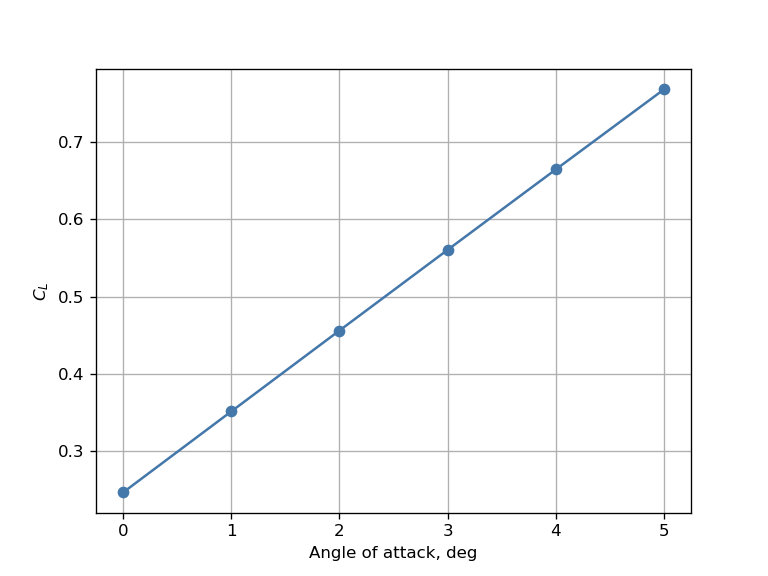

In [25]:
# Create figure with two subplots
fig, ax = plt.subplots()

# Plot normal force vs grid factor
ax.plot(benchmark_aerodynamic_aoa, lift_coefficient_array, 'o-')
ax.set_xlabel('Angle of attack, deg')
ax.set_ylabel('$C_L$')
ax.grid(True)
plt.show()

### Structural analysis <a class="anchor" id = "structural-analysis"></a>

In [26]:
# Generate base bdf input
stw_bdf, stw_layout = wingGeometry.create_base_bdf(
    target_length=converged_target_struct_length, parallel=True)

# Apply load
sol_105_bdf = stw_bdf.__deepcopy__({})
apply_benchmark_structural_analysis_load(
    layout=stw_layout, bdf=sol_105_bdf, pressure_set_id=PRESSURE_SET_ID,
    gravity_set_id=GRAVITY_SET_ID, load_set_id=LOAD_SET_ID,
    pressure_value=PRESSURE_LOAD)

# Request stress output
sol_105_bdf.case_control_deck.subcases[0].add_result_type(
    'STRESS', 'ALL', ['PLOT'])

# Run SOL 105 and return OP2 object
input_name = f"sol_105_benchmark_structural"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=sol_105_bdf, input_name=input_name, method_set_id=METHOD_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    static_load_set_id=LOAD_SET_ID, run_flag=False)

pyGeo Initialization Type is: iges
Found 6 surfaces in Iges File.
Projecting Super Nodes...
Projecting All Nodes...
Setting up Ribs...
Setting up Spars...
Setting up Skins and Stringers...
Setting up Spar Bars
Setting up Rib Bars
Computing Topology and Numbering...
Unique Nodes: 45483
Total Nodes: 65046
Writing .bdf File...


subcase=0 already exists...skipping


Nastran job sol_105_benchmark_structural.bdf completed
Wall time: 61.0 s


### Aeroelastic analysis <a class="anchor" id = "aeroelastic-analysis"></a>

Run SOL 144 and output aerodynamic forces.

Nastran job sol_144_benchmark_aeroelastic.bdf completed
Wall time: 24.0 s
CL: 0.56
Deformation:


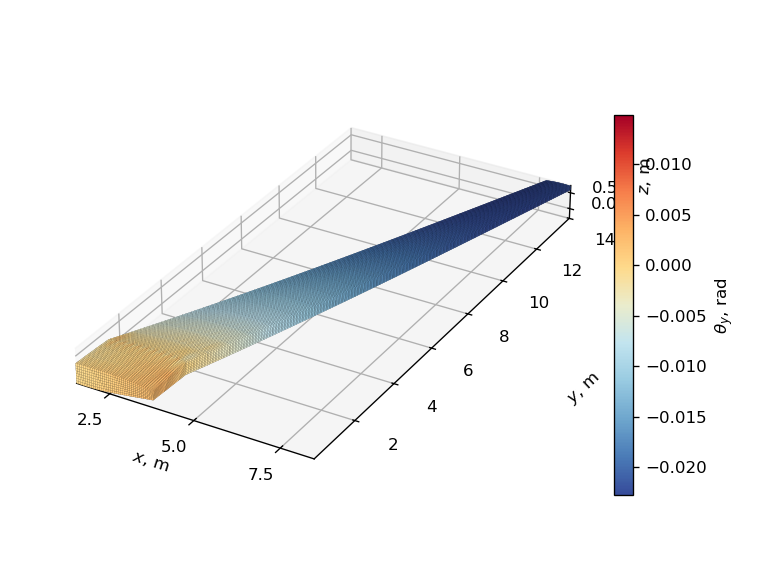

In [27]:
from pyNastran.op2.op2 import read_op2

# Define angle of attack for benchmark aeroelastic analysis
benchmark_aeroelastic_aoa = 3.25  # [deg]

# Define load reference axis and surface spline
intersection_nodes_ids = find_intersection_nodes(stw_layout, ["RIB", "SKIN"])
spline_nodes_ids = define_load_reference_axis(
        stw_bdf, intersection_nodes_ids, le_xyz_array, te_xyz_array)

# Apply gravity load
stw_bdf.add_grav(sid=GRAVITY_SET_ID, scale=9.81, N=np.array([0., 0., -1.]))

# Set up SOL 144
sol_144_bdf = stw_bdf.__deepcopy__({})
set_up_sol_144(
        sol_144_bdf, TRIM_SET_ID, cruise_mach, benchmark_aeroelastic_aoa,
        cruise_altitude, wingGeometry.meanAerodynamicChord,
        wingGeometry.semiSpan*2, wingGeometry.planformArea)

# Define aerodynamic model and surface spline
define_aerodynamic_model(
        sol_144_bdf, paero_id, [caero_id], p1_xyz_array, p4_xyz_array,
        chord_array, converged_target_aero_length, AIRFOIL_PATH)
define_surface_spline(
        sol_144_bdf, set1_sid, spline_nodes_ids, [caero_id])

# Add gravity load to external load set of the trim subcase
sol_144_bdf.case_control_deck.subcases[1].add_integer_type(
        'LOAD', GRAVITY_SET_ID)

# Request output of aerodynamic forces in pch file
sol_144_bdf.case_control_deck.subcases[0].add_result_type(
        'TRIMF', 'ALL', ['AIR'])

# Run analysis
input_name = "sol_144_benchmark_aeroelastic"
pynastran_utils.run_analysis(
        directory_path=ANALYSIS_DIRECTORY_PATH, bdf=sol_144_bdf,
        filename=input_name, run_flag=False)

# Read op2 file
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_144_op2 = read_op2(op2_filepath, load_geometry=True, debug=None)

# Find lift and plot deformation
full_vehicle_monitor_point = "AEROSG2D"
aerodynamic_loads = pynastran_utils.read_monitor_point_from_f06(
        f06_path=os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06'),
        monitor_point_name=full_vehicle_monitor_point)
normal_force = aerodynamic_loads['CZ'][0]
lift = normal_force*np.cos(np.deg2rad(benchmark_aeroelastic_aoa))
lieft_coefficient = lift/(
        cruise_dynamic_pressure*wingGeometry.planformArea)
print(f"CL: {lieft_coefficient:.2f}")
print("Deformation:")
_, ax, cbar = plot_utils.plot_deformation(
        op2=sol_144_op2, displacement_component='ry', colormap='sunset')
adjust_3d_plot(ax, cbar)
plt.show()

Run SOL 105 with aerodynamic forces from SOL 144.

Nastran job sol_105_benchmark_aeroelastic.bdf completed
Wall time: 38.0 s
Buckling load factor:     1.70


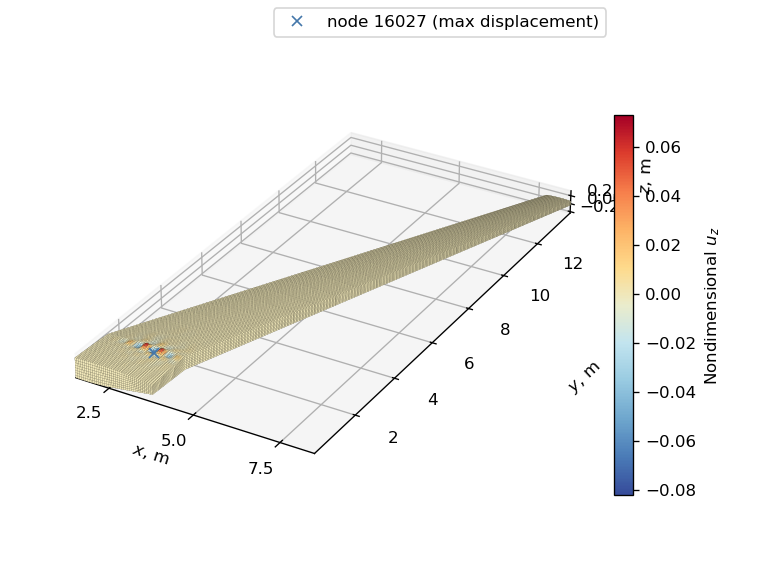

In [28]:
# Include the pch file with the forces obtained from the SOL 144 analysis in
# bdf object with the load reference axis
pch_filename = input_name + '.pch'
stw_bdf.add_include_file(pch_filename)

# Make a copy of the bdf object with load reference axis and combine
# aerodynamic and gravity loads with LOAD card
sol_105_bdf = stw_bdf.__deepcopy__({})
sol_105_bdf.add_load(
    sid=LOAD_SET_ID, scale=1., scale_factors=[1., 1.],
    load_ids=[GRAVITY_SET_ID, FORCE_SET_ID])

# Request stress output
sol_105_bdf.case_control_deck.subcases[0].add_result_type(
    'STRESS', 'ALL', ['PLOT'])

# Run SOL 105
input_name = "sol_105_benchmark_aeroelastic"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=sol_105_bdf, input_name=input_name,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    static_load_set_id=LOAD_SET_ID, method_set_id=METHOD_SET_ID,
    run_flag=False)

# Print buckling load factor and plot buckling mode
print(f"Buckling load factor: \
    {sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigr:.2f}")
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
    displacement_component='tz', colormap='sunset',
    displacement_amplification_factor=amplification_factor)
max_disp_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
    displacement_amplification_factor=amplification_factor)
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

Run SOL 106 with aerodynamic forces from SOL 144.

Nastran job sol_106_benchmark_aeroelastic.bdf completed
Wall time: 2191.0 s


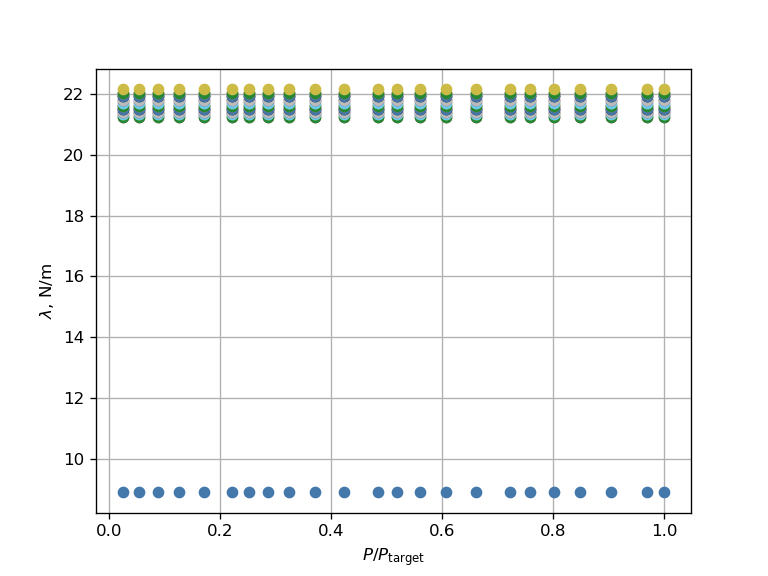

In [29]:
# Make a copy of the bdf object with load reference axis and combine
# aerodynamic and gravity loads with LOAD card
sol_106_bdf = stw_bdf.__deepcopy__({})
sol_106_bdf.add_load(
        sid=LOAD_SET_ID, scale=1., scale_factors=[1., 1.],
        load_ids=[GRAVITY_SET_ID, FORCE_SET_ID])

# Request stress output
sol_106_bdf.case_control_deck.subcases[0].add_result_type(
        'NLSTRESS', 'ALL', ['PLOT'])

# Set up arc-lengthm method and create subcase
pynastran_utils.set_up_arc_length_method(
        bdf=sol_106_bdf, max_iter=3, conv='PU', eps_u=5e-6, eps_p=5e-6,
        max_bisect=20, minalr=1e-5, desiter=4, maxinc=500)
pynastran_utils.create_static_load_subcase(
        bdf=sol_106_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID)

# Run nonlinear analysis
input_name = "sol_106_benchmark_aeroelastic"
sol_106_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
        bdf=sol_106_bdf, method_set_id=METHOD_SET_ID,
        analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
        no_eigenvalues=NO_EIGENVALUES, upper_eig=UPPER_EIGENVALUE,
        run_flag=False)

# Find id of tip node
tip_node_id = len(sol_106_bdf.nodes) - 2  # id of tip c/4 node

# Read load and displacment histories from OP2 object
plot_nodes_ids = [max_disp_node_id, tip_node_id]  # list of node ids where displacement is monitored
load_factors, _, displacements =\
pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=plot_nodes_ids)
nondimensional_loads = load_factors[FIRST_SUBCASE_ID]

# Read eigenvalues from f06 file
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path of f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)  # read eigenvalues from f06 file

# Plot eigenvalue diagram
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{target}$")
plt.show()

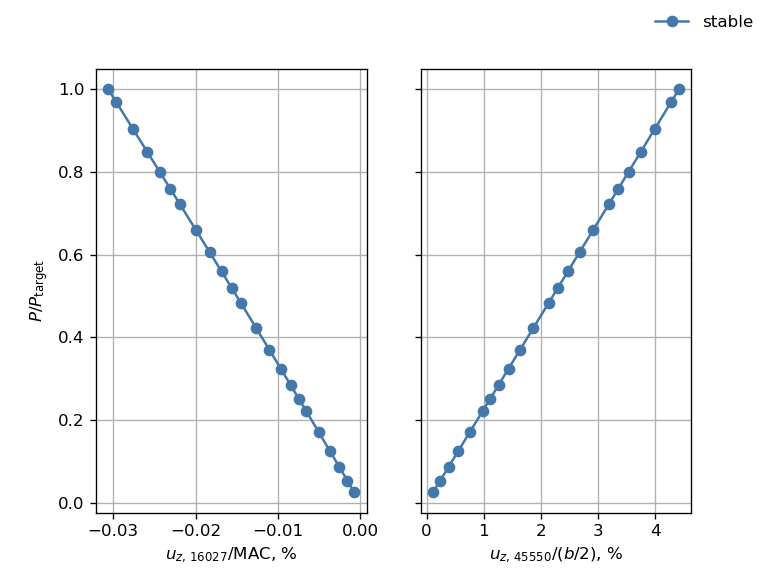

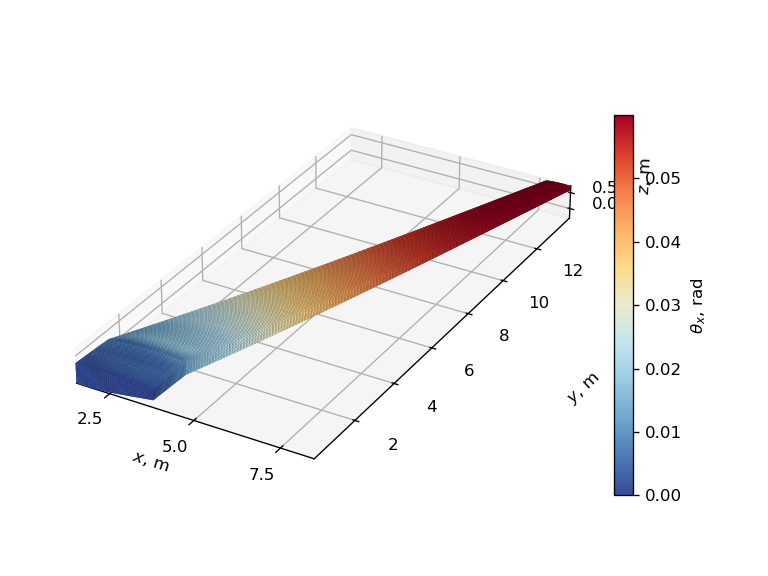

In [30]:
# Create lists of reference lengths and labels for the load-displacement plots
reference_lengths = [wingGeometry.meanAerodynamicChord, wingGeometry.semiSpan]  # reference lengths for the displacements
reference_lengths_labels = ["\mathrm{MAC}", r"\left(b/2\right)"]  # reference labels for the displacements

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, sharey=True)

# Loop over the subplots
for i, node_id in enumerate(plot_nodes_ids):
        nondimensional_disp = displacements[node_id][FIRST_SUBCASE_ID][
                :, Z_COMPONENT_INDEX]/reference_lengths[i]*100
        plot_utils.plot_2d_load_displacements_stability(  # plot load-displacement curve highlighting stable and unstable segments
                axes[i],
                nondimensional_disp,
                nondimensional_loads,
                eigenvalues,
                MARKERS[0],
                COLORS[0])
        axes[i].set_xlabel(
                f"$u_{{z,\,{node_id}}}/{reference_lengths_labels[i]}$, %")  # set x-axis label
        axes[i].grid(visible=True)  # enable grid
        axes[0].set_ylabel("$P/P_\mathrm{target}$")  # set y-axis label

# Add legend and show plot
stable_line = Line2D(
        [0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0],
        label="stable")
fig.legend(handles=[stable_line], frameon=False)  # add legend
plt.show()

# Plot deformation at target load
_, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2, displacement_component='rx', colormap='sunset')
adjust_3d_plot(ax, cbar)
plt.show()

## Optimizations <a class="anchor" id = "optimizations"></a>

***

### Linear buckling optimization <a class="anchor" id = "linear-optimization"></a>

In [31]:
from mphys import Multipoint
import openmdao.api as om
from resources.NastranBuilder import NastranBuilder
from mphys.scenario_structural import ScenarioStructural
from resources.STW.performanceCalc import LandingGrossMass


panels_y_coords = ribs_y_coords[:-1] + np.diff(ribs_y_coords)/2
min_thickness = .6e-3  # [m]
max_panel_thickness = wingGeometry.panelThickness*10  # [m]
max_stiffener_thickness = wingGeometry.stiffenerHeight/5  # [m]

# Initial thickness vectors
initial_panel_thickness_vector = wingGeometry.panelThickness*np.ones(3)
initial_stiffener_thickness_vector = wingGeometry.stiffenerThickness*np.ones(3)

PAYLOAD_MASS = 14.5e3  # kg
AIRFRAME_MASS = 25e3  # kg
RESERVE_FUEL_MASS = 2e3  # kg

maneuver_altitude = 0.  # [m]
maneuver_mach = .458
maneuver_dynamic_pressure = mach_altitude_to_dynamic_pressure(
    maneuver_mach, maneuver_altitude)
sol_144_bdf.trims[TRIM_SET_ID].mach = maneuver_mach
sol_144_bdf.trims[TRIM_SET_ID].q = maneuver_dynamic_pressure
initial_maneuver_aoa = [8.96, -6.4]  # [deg]

sol_105_bdf.methods[METHOD_SET_ID].nd = NO_EIGENVALUES
sol_105_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[1] = 1.5


class NastranDVComp(om.ExplicitComponent):
    """
    Component for grouping thickness design variables of the different
    structural parts into a global design vector.
    """
    def initialize(self):
        self.options.declare(
            "layout",
            default=None,
            desc="Layout object containing the structural layout",
            recordable=False,
        )
        
    def setup(self):
        self.layout = self.options["layout"]
        self.add_input(
            "t_ribs", shape_by_conn=True, desc="Ribs thickness", units="m")
        self.add_input(
            "t_front_spar", shape_by_conn=True, desc="Front spar thickness",
            units="m")
        self.add_input(
            "t_rear_spar", shape_by_conn=True, desc="Rear spar thickness",
            units="m")
        self.add_input(
            "t_top_skin", shape_by_conn=True, desc="Top skin thickness",
            units="m")
        self.add_input(
            "t_bottom_skin", shape_by_conn=True, desc="Bottom skin thickness",
            units="m")
        self.add_input(
            "t_top_stiffeners", shape_by_conn=True,
            desc="Top stiffeners thickness", units="m")
        self.add_input(
            "t_bottom_stiffeners", shape_by_conn=True,
            desc="Bottom stiffeners thickness", units="m")
        self.add_output(
            "dv_struct", shape=len(self.layout.faceDescript),
            desc="Structural design vector")
    
    def compute(self, inputs, outputs):
        # Initialize design vector
        dv_struct = np.empty(len(self.layout.faceDescript))
        descriptions = np.array(self.layout.faceDescript)
        
        # Ribs
        rib_indices = np.where(np.char.find(descriptions, "RIB") >= 0)[0]
        dv_struct[rib_indices] = np.repeat(
            inputs["t_ribs"], self.layout.nspars - 1)
        
        # Spars
        spar_indices = np.where(np.char.find(descriptions, "SPAR") >= 0)[0]
        dv_struct[spar_indices] = np.hstack(
            (inputs["t_front_spar"], inputs["t_rear_spar"]))
        
        # Top skin
        top_skin_indices = np.where(
            np.char.find(descriptions, "U_SKIN") >= 0)[0]
        dv_struct[top_skin_indices] = np.repeat(
            inputs["t_top_skin"], self.layout.nspars - 1)
        
        # Bottom skin
        bottom_skin_indices = np.where(
            np.char.find(descriptions, "L_SKIN") >= 0)[0]
        dv_struct[bottom_skin_indices] = np.repeat(
            inputs["t_bottom_skin"], self.layout.nspars - 1)
        
        # Top skin stiffeners
        top_stiffeners_indices = np.where(
            np.char.find(descriptions, "U_STRING") >= 0)[0]
        dv_struct[top_stiffeners_indices] = np.repeat(
            inputs["t_top_stiffeners"], self.layout.nspars - 2)
        
        # Bottom skin stiffeners
        bottom_stiffeners_indices = np.where(
            np.char.find(descriptions, "L_STRING") >= 0)[0]
        dv_struct[bottom_stiffeners_indices] = np.repeat(
            inputs["t_bottom_stiffeners"], self.layout.nspars - 2)
        
        # Store design vector
        outputs["dv_struct"] = dv_struct
        
        
class LoadFactor(om.ExplicitComponent):
    def setup(self):
        self.add_input("lift", units="N")
        self.add_input("aircraft_mass", units="kg")
        self.add_output("load_factor")
        
    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite
        difference method.
        """
        self.declare_partials('*', '*', method='fd', step=1e-6)
        
    def compute(self, inputs, outputs):
        outputs["load_factor"] = inputs["lift"]/(9.81*inputs["aircraft_mass"])


class Linear(Multipoint):
    def initialize(self):
        self.options.declare('sol_144_bdf', default=None)
        self.options.declare('sol_105_bdf', default=None)
        self.options.declare('input_name_suffix', default='')
        self.options.declare('run_flag', default=True)

    def setup(self):
        #----------------#
        # Initialization #
        #----------------#
        self.sol_144_bdf = self.options['sol_144_bdf']
        self.sol_105_bdf = self.options['sol_105_bdf']
        self.input_name_suffix = self.options['input_name_suffix']
        self.run_flag = self.options['run_flag']

        #-----#
        # IVC #
        #-----#
        ivc = self.add_subsystem('ivc', om.IndepVarComp(), promotes=['*'])
        ivc.add_output(
            "yield_strength", val=wingGeometry.yieldStrength, units="Pa")
        ivc.add_output(
            "maneuver_aoa",
            val=initial_maneuver_aoa,
            units="deg")

        #--------------------------#
        # Interpolation components #
        #--------------------------#    
        # Function to add interpolation component
        def add_interp_comp(y_coords, part_name, y_cp_val):
            interp_comp = om.SplineComp(
                method='slinear',
                x_cp_val=wingGeometry.LESparCoords[:, 1],
                x_interp_val=y_coords)
            interp_comp.add_spline(
                y_cp_name='t_cp', y_interp_name='t_interp',
                y_cp_val=y_cp_val, y_units='m')
            self.add_subsystem(f'{part_name}_interp', interp_comp)
            self.connect(
                f'{part_name}_interp.t_interp', f'dv_comp.t_{part_name}')
        
        # Ribs
        add_interp_comp(ribs_y_coords, 'ribs', initial_panel_thickness_vector)
        
        
        # Spars and skin
        for part in ['front_spar', 'rear_spar', 'top_skin', 'bottom_skin']:
            add_interp_comp(
                panels_y_coords, part, initial_panel_thickness_vector)
            
        # Stiffeners
        for part in ['top_stiffeners', 'bottom_stiffeners']:
            add_interp_comp(
                panels_y_coords, part, initial_stiffener_thickness_vector
            )
            
        #-------------------------#
        # Design vector assembler #
        #-------------------------#
        self.add_subsystem('dv_comp', NastranDVComp(layout=stw_layout))

        #----------------------------#
        # Add builders and scenarios #
        #----------------------------#
        bdf_list = [self.sol_144_bdf, self.sol_105_bdf]
        for i, flight_point in enumerate(["pull_up", "push_down"]):
            for j, sol_sequence in enumerate(["sol_144", "sol_105"]):
                # Nastran builder
                input_name = sol_sequence + "_" + flight_point +\
                    self.input_name_suffix
                bdf_list[j]._xref = False
                bdf = bdf_list[j].__deepcopy__({})
                bdf.cross_reference(xref_loads=False)
                builder = NastranBuilder(
                    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                    input_name=input_name, bdf=bdf,
                    run_flag=self.run_flag, trim_id=TRIM_SET_ID)
                builder.initialize()
                # Structures only scenario
                scenario_name = flight_point + "_" + sol_sequence
                self.mphys_add_scenario(
                    scenario_name,
                    ScenarioStructural(struct_builder=builder))
                # Structural mesh
                self.add_subsystem(
                    scenario_name + "_mesh",
                    builder.get_mesh_coordinate_subsystem())
                # Connections
                self.connect(
                    "yield_strength", scenario_name + ".yield_strength")
                self.connect(
                    scenario_name + "_mesh.x_struct0",
                    scenario_name + ".x_struct0")
                self.connect("dv_comp.dv_struct", scenario_name + ".dv_struct")
            # Add angle of attack connection to the SOL 144 scenario
            self.connect(
                "maneuver_aoa", flight_point + "_sol_144.aoa",
                src_indices=[i])
            # Include the pch file with the forces obtained from the SOL 144
            # analysis in the SOL 105 bdf
            builder.solver.bdf.reject_lines[0][0] =\
                "INCLUDE 'sol_144_" + flight_point + self.input_name_suffix +\
                    ".pch'"
                
        #--------------------#
        # Landing gross mass #
        #--------------------#
        lgm_comp = LandingGrossMass(
            payloadMass=PAYLOAD_MASS,
            airframeMass=AIRFRAME_MASS,
            reserveFuelMass=RESERVE_FUEL_MASS
        )
        self.add_subsystem('lgm_comp', lgm_comp)
        self.connect("pull_up_sol_105.mass", "lgm_comp.wingMass")
        
        #-------------#
        # Load factor #
        #-------------#
        for maneuver in ["pull_up", "push_down"]:
            lf_comp = LoadFactor()
            self.add_subsystem(f'{maneuver}_lf_comp', lf_comp)
            self.connect(
                f'{maneuver}_sol_144.lift', f'{maneuver}_lf_comp.lift')
            self.connect(
                f'lgm_comp.landingGrossMass', f'{maneuver}_lf_comp.aircraft_mass')

In [32]:
linear_problem = om.Problem(name="linear_problem")
linear_problem.model = Linear(
    sol_144_bdf=sol_144_bdf,
    sol_105_bdf=sol_105_bdf,
    input_name_suffix="_start",
    run_flag=False)
linear_problem.setup()

linear_problem.run_model()

mass_0 = linear_problem['pull_up_sol_105.mass'][0]
pull_up_ks_stress_0 = linear_problem['pull_up_sol_105.ks_stress'][0]
push_down_ks_stress_0 = linear_problem['push_down_sol_105.ks_stress'][0]

print(f"wing mass =          {linear_problem['pull_up_sol_105.mass'][0]:.0f} kg")
print(f"landing gross mass = {linear_problem['lgm_comp.landingGrossMass'][0]:.0f} kg")
print(f"pull-up maneuver lift =          {linear_problem['pull_up_sol_144.lift'][0]:.0f} N")
print(f"pull-up load factor =            {linear_problem['pull_up_lf_comp.load_factor'][0]:.2f}")
print(f"pull-up maneuver ks stress =     {linear_problem['pull_up_sol_105.ks_stress'][0]:.0f} Pa")
print(f"pull-up maneuver ks buckling =   {linear_problem['pull_up_sol_105.ks_buckling'][0]:.2f}")
print(f"push-down maneuver lift =        {linear_problem['push_down_sol_144.lift'][0]:.0f} N")
print(f"push-down load factor =          {linear_problem['push_down_lf_comp.load_factor'][0]:.2f}")
print(f"push-down maneuver ks stress =   {linear_problem['push_down_sol_105.ks_stress'][0]:.0f} Pa")
print(f"push-down maneuver ks buckling = {linear_problem['push_down_sol_105.ks_buckling'][0]:.2f}")

/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'pull_up_sol_144_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation (MPI/PETSc) available. The default non-distributed vectors will be used.
/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'pull_up_sol_105_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation (MPI/PETSc) available. The default non-distributed vectors will be used.
/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'push_down_sol_144_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation 

Nastran job sol_144_pull_up_start.bdf completed
Wall time: 22.0 s
Nastran job sol_105_pull_up_start.bdf completed
Wall time: 91.0 s
Nastran job sol_144_push_down_start.bdf completed
Wall time: 22.0 s
Nastran job sol_105_push_down_start.bdf completed
Wall time: 43.0 s
wing mass =          1470 kg
landing gross mass = 44439 kg
pull-up maneuver lift =          1089907 N
pull-up load factor =            2.50
pull-up maneuver ks stress =     257782464 Pa
pull-up maneuver ks buckling =   0.54
push-down maneuver lift =        -437377 N
push-down load factor =          -1.00
push-down maneuver ks stress =   -158205808 Pa
push-down maneuver ks buckling = -0.07


Set up optimization problem.

In [33]:
# Remove start suffix from input names
linear_problem.model.options['input_name_suffix'] = ""
# linear_problem.model.options['run_flag'] = True

# Set default initial design variables
for part in ['ribs', 'front_spar', 'rear_spar', 'top_skin', 'bottom_skin']:
    linear_problem.model.set_input_defaults(
        f'{part}_interp.t_cp', initial_panel_thickness_vector)
for part in ['top_stiffeners', 'bottom_stiffeners']:
    linear_problem.model.set_input_defaults(
        f'{part}_interp.t_cp', initial_stiffener_thickness_vector)

# Choose optimizer
linear_problem.driver = om.ScipyOptimizeDriver()
linear_problem.driver.options['optimizer'] = 'COBYLA'
linear_problem.driver.options['tol'] = OPTIMIZER_TOLERANCE
linear_problem.driver.options['maxiter'] = 400

# Add objective
linear_problem.model.add_objective('pull_up_sol_105.mass', ref=mass_0)

# Add design variables
for part in ['ribs', 'front_spar', 'rear_spar', 'top_skin', 'bottom_skin']:
    linear_problem.model.add_design_var(
        f'{part}_interp.t_cp',
        lower=min_thickness,
        upper=max_panel_thickness,
        ref=wingGeometry.panelThickness,
        ref0=min_thickness)
for part in ['top_stiffeners', 'bottom_stiffeners']:
    linear_problem.model.add_design_var(
        f'{part}_interp.t_cp',
        lower=min_thickness,
        upper=max_stiffener_thickness,
        ref=wingGeometry.stiffenerThickness,
        ref0=min_thickness)
linear_problem.model.add_design_var(
    'maneuver_aoa',
    lower=-11.,
    upper=12.5,
    ref=initial_maneuver_aoa[0],
    ref0=-11.)

# Add constraints
linear_problem.model.add_constraint(
    'pull_up_sol_105.ks_stress', upper=0., ref=np.abs(pull_up_ks_stress_0))
linear_problem.model.add_constraint('pull_up_sol_105.ks_buckling', upper=0.)
linear_problem.model.add_constraint(
    'push_down_sol_105.ks_stress', upper=0., ref=np.abs(push_down_ks_stress_0))
linear_problem.model.add_constraint('push_down_sol_105.ks_buckling', upper=0.)
linear_problem.model.add_constraint(
    'pull_up_lf_comp.load_factor', lower=2.499, upper=2.501)
linear_problem.model.add_constraint(
    'push_down_lf_comp.load_factor', lower=-1.001, upper=-0.999)

Run optimization.

In [34]:
# Set up print options for numpy arrays
np.set_printoptions(precision=5, suppress=True)

# Define recorder file path
recorder_filename = "linear_optimization"
recorder_filepath = os.path.join(
    ANALYSIS_DIRECTORY_PATH, recorder_filename + '.sql')

# Define whether to run optimization or not
run_optimization = False

if run_optimization:
    # If optimization is to be run, set up recorder and run optimization
    recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
    linear_problem.driver.add_recorder(recorder)  # attach recorder to driver
    linear_problem.setup()  # re-setup problem before running optimization
    linear_problem.set_solver_print(0)  # disable solver output
    linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']
    linear_problem.run_driver()
else:
    # If optimization is not to be run, call final setup to enable driver
    # variables list
    linear_problem.setup()
    linear_problem.final_setup()
    
# Clean up resources prior to exit
linear_problem.cleanup()

/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'pull_up_sol_144_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation (MPI/PETSc) available. The default non-distributed vectors will be used.
/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'pull_up_sol_105_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation (MPI/PETSc) available. The default non-distributed vectors will be used.
/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'push_down_sol_144_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation 

----------------
Design Variables
----------------
name                           val        size  
-----------------------------  ---------  ---- 
ribs_interp.t_cp               |1.73205|  3     
front_spar_interp.t_cp         |1.73205|  3     
rear_spar_interp.t_cp          |1.73205|  3     
top_skin_interp.t_cp           |1.73205|  3     
bottom_skin_interp.t_cp        |1.73205|  3     
top_stiffeners_interp.t_cp     |1.73205|  3     
bottom_stiffeners_interp.t_cp  |1.73205|  3     
maneuver_aoa                   |1.02621|  2     

-----------
Constraints
-----------
name                           val   size  
-----------------------------  ----  ---- 
pull_up_sol_105.ks_stress      [0.]  1     
pull_up_sol_105.ks_buckling    [1.]  1     
push_down_sol_105.ks_stress    [0.]  1     
push_down_sol_105.ks_buckling  [1.]  1     
pull_up_lf_comp.load_factor    [1.]  1     
push_down_lf_comp.load_factor  [1.]  1     

----------
Objectives
----------
name                  val        size 

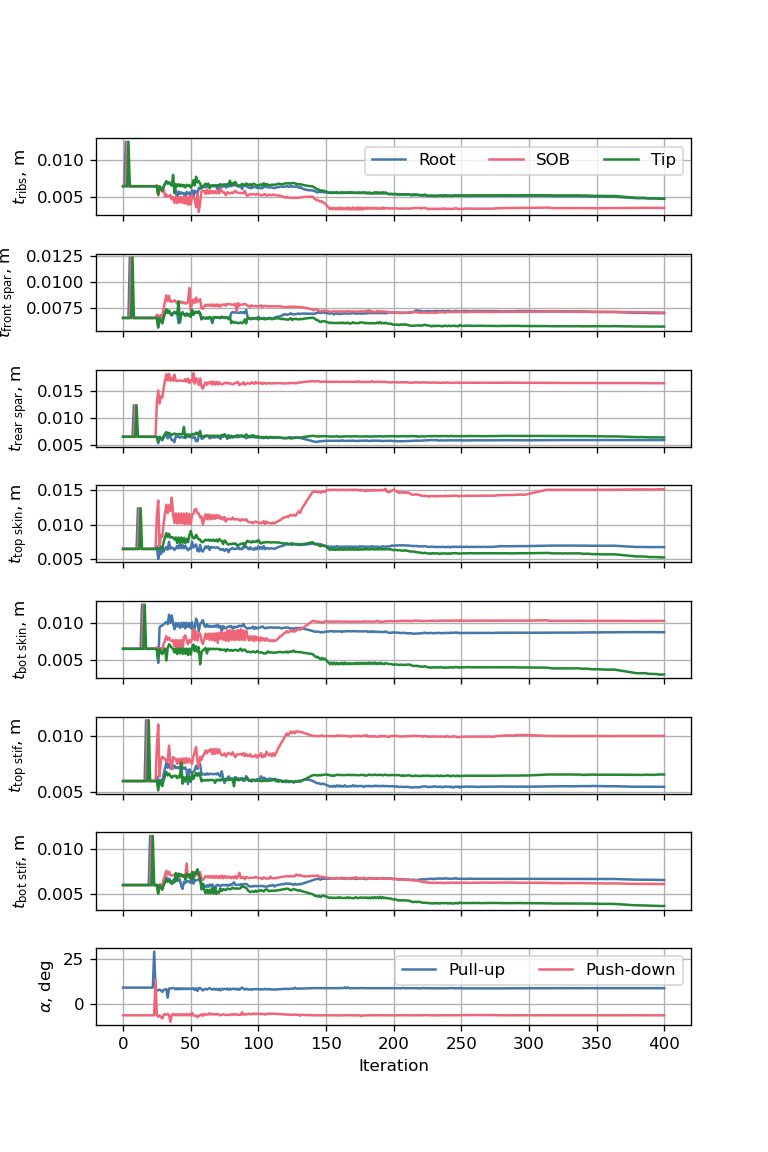

Requested variables at last iteration:
- pull_up_sol_105.mass: [1813.46744]
- pull_up_sol_105.ks_stress: [-824832.]
- pull_up_sol_105.ks_buckling: [-0.0016]
- push_down_sol_105.ks_stress: [-2.45226e+08]
- push_down_sol_105.ks_buckling: [-0.50926]
- pull_up_lf_comp.load_factor: [2.49424]
- push_down_lf_comp.load_factor: [-1.00483]


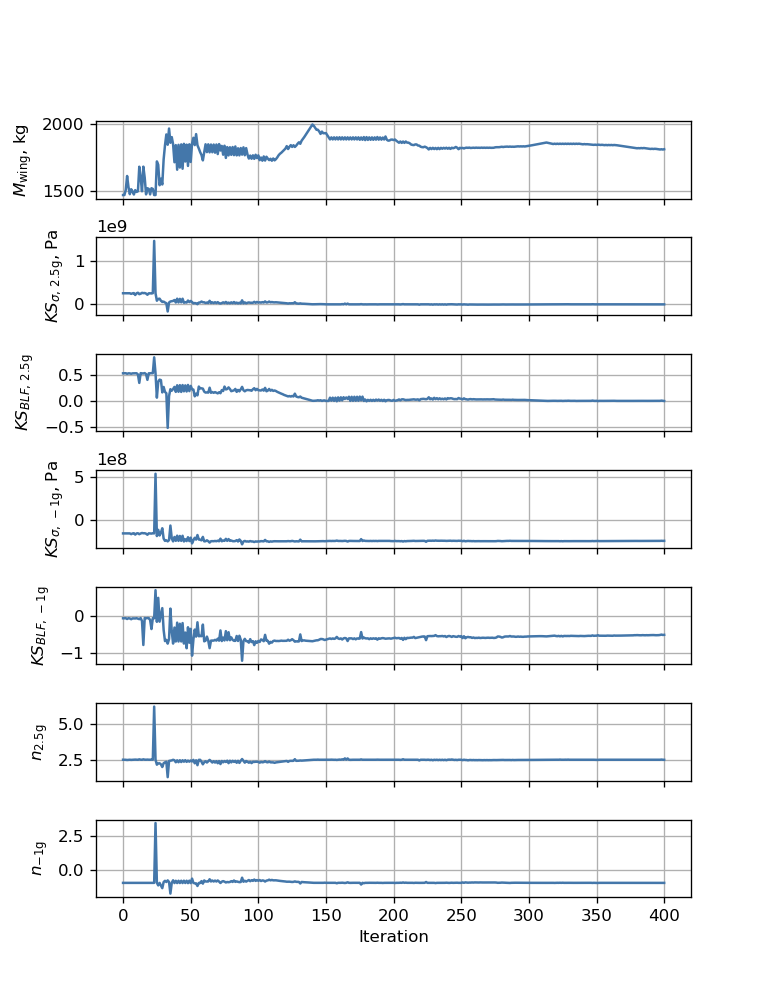

In [35]:
from resources.optimization_utils import plot_optimization_history

# Find design variables and objectives/constraints
driver_variables = linear_problem.list_driver_vars()

# Plot histories of design variables
design_variables = [var[0] for var in driver_variables['design_vars']]
design_variable_labels = [
    "$t_{\mathrm{ribs}}$, m", "$t_{\mathrm{front\ spar}}$, m",
    "$t_{\mathrm{rear\ spar}}$, m", "$t_{\mathrm{top\ skin}}$, m",
    "$t_{\mathrm{bot\ skin}}$, m", "$t_{\mathrm{top\ stif}}$, m",
    "$t_{\mathrm{bot\ stif}}$, m", "$\\alpha$, deg"]
_, axes, design_variable_histories = plot_optimization_history(
    recorder_filepath=recorder_filepath,
    variable_names=design_variables,
    y_labels=design_variable_labels)
axes[0].legend(["Root", "SOB", "Tip"], ncol=3)
axes[-1].legend(["Pull-up", "Push-down"], ncol=2)
plt.show()

# Plot histories of objective and constraints
objective_constraints = [var[0] for var in driver_variables['objectives']] +\
    [var[0] for var in driver_variables['constraints']]
objective_constraints_labels = [
    "$M_{\mathrm{wing}}$, kg", "$KS_{\sigma,\,2.5\mathrm{g}}$, Pa",
    "$KS_{BLF,\,2.5\mathrm{g}}$", "$KS_{\sigma,\,-1\mathrm{g}}$, Pa",
    "$KS_{BLF,\,-1\mathrm{g}}$", "$n_{2.5\mathrm{g}}$", "$n_{-1\mathrm{g}}$"]
_, axes, objective_constraints_histories = plot_optimization_history(
    recorder_filepath=recorder_filepath,
    variable_names=objective_constraints,
    y_labels=objective_constraints_labels)
plt.show()

Plot critical buckling mode of pull-up maneuver of linearly optimized structure.

/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


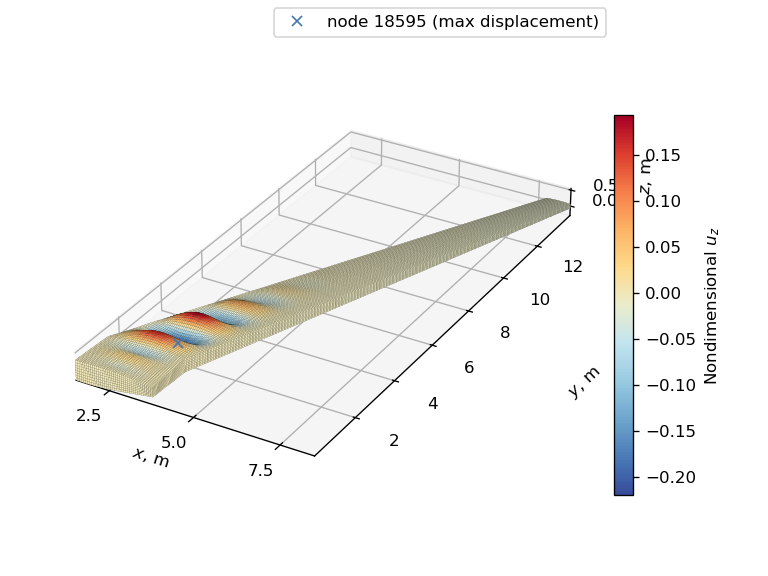

In [36]:
# Read op2 file of analysis of optimized structure
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, "sol_105_pull_up.op2")
sol_105_op2 = read_op2(op2_filepath, load_geometry=True, debug=None)

# Plot critical buckling mode and highlight max displacement node
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz',
    colormap='sunset', displacement_amplification_factor=amplification_factor)
max_disp_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2,
    displacement_amplification_factor=amplification_factor)
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

Define nonlinear problem.

In [37]:
# Apply safety factor to applied loads
sol_106_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[1] = 1.5

# Find value of thickness vectors at the end of the linear optimization
linear_opt_thickness_vectors = [
    history[-1] for history in design_variable_histories.values()]
linear_opt_thickness_vectors = linear_opt_thickness_vectors[:-1]

class Nonlinear(Multipoint):
    def initialize(self):
        self.options.declare('sol_106_bdf', default=None)
        self.options.declare('input_name_suffix', default='')
        self.options.declare('run_flag', default=True)

    def setup(self):
        #----------------#
        # Initialization #
        #----------------#
        self.sol_106_bdf = self.options['sol_106_bdf']
        self.input_name_suffix = self.options['input_name_suffix']
        self.run_flag = self.options['run_flag']

        #-----#
        # IVC #
        #-----#
        ivc = self.add_subsystem('ivc', om.IndepVarComp(), promotes=['*'])
        ivc.add_output(
            "yield_strength", val=wingGeometry.yieldStrength, units="Pa")

        #--------------------------#
        # Interpolation components #
        #--------------------------#    
        # Function to add interpolation component
        def add_interp_comp(y_coords, part_name, y_cp_val):
            interp_comp = om.SplineComp(
                method='slinear',
                x_cp_val=wingGeometry.LESparCoords[:, 1],
                x_interp_val=y_coords)
            interp_comp.add_spline(
                y_cp_name='t_cp', y_interp_name='t_interp',
                y_cp_val=y_cp_val, y_units='m')
            self.add_subsystem(f'{part_name}_interp', interp_comp)
            self.connect(
                f'{part_name}_interp.t_interp', f'dv_comp.t_{part_name}')
        
        # Ribs
        add_interp_comp(
                ribs_y_coords, 'ribs', linear_opt_thickness_vectors[0])
        
        # Remaining parts
        for i, part in enumerate([
            'front_spar', 'rear_spar', 'top_skin', 'bottom_skin',\
                'top_stiffeners', 'bottom_stiffeners']):
            add_interp_comp(
                panels_y_coords, part, linear_opt_thickness_vectors[i + 1])
            
        #-------------------------#
        # Design vector assembler #
        #-------------------------#
        self.add_subsystem('dv_comp', NastranDVComp(layout=stw_layout))

        #----------------------------#
        # Add builders and scenarios #
        #----------------------------#
        for i, flight_point in enumerate(["pull_up", "push_down"]):
            # Nastran builder
            input_name = "sol_106_" + flight_point + self.input_name_suffix
            self.sol_106_bdf._xref = False
            bdf = self.sol_106_bdf.__deepcopy__({})
            bdf.cross_reference(xref_loads=False)
            builder = NastranBuilder(
                analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                input_name=input_name, bdf=bdf, run_flag=self.run_flag)
            builder.initialize()
            # Include the pch file with the forces obtained from SOL 144
            builder.solver.bdf.reject_lines[0][0] =\
                "INCLUDE 'sol_144_" + flight_point + ".pch'"
            # Structures only scenario
            scenario_name = flight_point + "_106"
            self.mphys_add_scenario(
                scenario_name,
                ScenarioStructural(struct_builder=builder))
            # Structural mesh
            self.add_subsystem(
                scenario_name + "_mesh",
                builder.get_mesh_coordinate_subsystem())
            # Connections
            self.connect(
                "yield_strength", scenario_name + ".yield_strength")
            self.connect(
                scenario_name + "_mesh.x_struct0",
                scenario_name + ".x_struct0")
            self.connect("dv_comp.dv_struct", scenario_name + ".dv_struct")

Run starting point of nonlinear optimization.

In [ ]:
nonlinear_problem = om.Problem(name="nonlinear_problem3")
nonlinear_problem.model = Nonlinear(
    sol_106_bdf=sol_106_bdf,
    input_name_suffix="_start",
    run_flag=True)
nonlinear_problem.setup()

nonlinear_problem.run_model()

mass_0 = nonlinear_problem['pull_up_sol_106.mass'][0]
pull_up_ks_stress_0 = nonlinear_problem['pull_up_sol_106.ks_stress'][0]
pull_up_ks_stability_0 = nonlinear_problem['pull_up_sol_106.ks_stability'][0]
push_down_ks_stress_0 = nonlinear_problem['push_down_sol_106.ks_stress'][0]
push_down_ks_stability_0 = nonlinear_problem['push_down_sol_106.ks_stability'][0]

print(f"wing mass =          {nonlinear_problem['pull_up_sol_106.mass'][0]:.0f} kg")
print(f"pull-up maneuver ks stress =      {nonlinear_problem['pull_up_sol_106.ks_stress'][0]:.0f} Pa")
print(f"pull-up maneuver ks stability =   {nonlinear_problem['pull_up_sol_106.ks_stability'][0]:.2f} N/m")
print(f"push-down maneuver ks stress =    {nonlinear_problem['push_down_sol_106.ks_stress'][0]:.0f} Pa")  
print(f"push-down maneuver ks stability = {nonlinear_problem['push_down_sol_106.ks_stability'][0]:.2f} N/m")

/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'pull_up_106_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation (MPI/PETSc) available. The default non-distributed vectors will be used.
/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/component.py:203: DistributedComponentWarning:'push_down_106_mesh' <class NastranMesh>: Component contains distributed variables, but there is no distributed vector implementation (MPI/PETSc) available. The default non-distributed vectors will be used.
/home/fmamitrotta/anaconda3/envs/aeroelastic-opt-benchmark/lib/python3.10/site-packages/openmdao/core/group.py:2885: UnitsWarning:<model> <class Nonlinear>: Output 'ivc.yield_strength' with units of 'Pa' is connected to input 'pull_up_106.struct_post.struct_function.yield_strength' which has

Set up nonlinear optimization problem.

In [ ]:
# Remove start suffix from input names
dmap_stop = sol_106_bdf.executive_control_lines[1].replace("nobuckle", "stop")  # get include string for DMAP stopping the analysis after the first negative eigenvalue is found
sol_106_bdf.executive_control_lines[1] = dmap_stop  # change DMAP command to store eigenvectors
nonlinear_problem.model.options['input_name_suffix'] = ""
# linear_problem.model.options['run_flag'] = True

# Set default initial design variables
for i, part in enumerate([
    'ribs', 'front_spar', 'rear_spar', 'top_skin', 'bottom_skin',\
        'top_stiffeners', 'bottom_stiffeners']):
    nonlinear_problem.model.set_input_defaults(
        f'{part}_interp.t_cp', linear_opt_thickness_vectors[i])

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'
nonlinear_problem.driver.options['tol'] = OPTIMIZER_TOLERANCE
nonlinear_problem.driver.options['maxiter'] = 400

# Add objective
nonlinear_problem.model.add_objective('pull_up_sol_106.mass', ref=mass_0)

# Add design variables
for part in ['ribs', 'front_spar', 'rear_spar', 'top_skin', 'bottom_skin']:
    nonlinear_problem.model.add_design_var(
        f'{part}_interp.t_cp',
        lower=min_thickness,
        upper=max_panel_thickness,
        ref=wingGeometry.panelThickness,
        ref0=min_thickness)
for part in ['top_stiffeners', 'bottom_stiffeners']:
    nonlinear_problem.model.add_design_var(
        f'{part}_interp.t_cp',
        lower=min_thickness,
        upper=max_stiffener_thickness,
        ref=wingGeometry.stiffenerThickness,
        ref0=min_thickness)

# Add constraints
nonlinear_problem.model.add_constraint(
    'pull_up_sol_106.ks_stress', upper=0., ref=np.abs(pull_up_ks_stress_0))
nonlinear_problem.model.add_constraint(
    'pull_up_sol_106.ks_stability', upper=0.,
    ref=np.abs(pull_up_ks_stability_0))
nonlinear_problem.model.add_constraint(
    'pull_up_sol_106.load_factor', lower=.999)
nonlinear_problem.model.add_constraint(
    'push_down_sol_106.ks_stress', upper=0., ref=np.abs(push_down_ks_stress_0))
nonlinear_problem.model.add_constraint(
    'push_down_sol_106.ks_stability', upper=0.,
    ref=np.abs(push_down_ks_stability_0))
nonlinear_problem.model.add_constraint(
    'push_down_sol_106.load_factor', upper=.999)

Run nonlinear optimization.

In [ ]:
# Define recorder file path
recorder_filename = "nonlinear_optimization"
recorder_filepath = os.path.join(
    ANALYSIS_DIRECTORY_PATH, recorder_filename + '.sql')

# Define whether to run optimization or not
run_optimization = True

if run_optimization:
    # If optimization is to be run, set up recorder and run optimization
    recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
    nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to driver
    nonlinear_problem.setup()  # re-setup problem before running optimization
    nonlinear_problem.set_solver_print(0)  # disable solver output
    nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']
    nonlinear_problem.run_driver()
else:
    # If optimization is not to be run, call final setup to enable driver
    # variables list
    nonlinear_problem.final_setup()
    
# Clean up resources prior to exit
nonlinear_problem.cleanup()

Plot optimiation history.

In [ ]:
from resources.optimization_utils import plot_optimization_history

driver_variables = nonlinear_problem.list_driver_vars()

design_variables = [var[0] for var in driver_variables['design_vars']]
design_variable_labels = [
    "$t_{\mathrm{ribs}}$, m", "$t_{\mathrm{front\ spar}}$, m",
    "$t_{\mathrm{rear\ spar}}$, m", "$t_{\mathrm{top\ skin}}$, m",
    "$t_{\mathrm{bot\ skin}}$, m", "$t_{\mathrm{top\ stif}}$, m",
    "$t_{\mathrm{bot\ stif}}$, m"]
_, axes, design_variable_histories = plot_optimization_history(
    recorder_filepath=recorder_filepath,
    variable_names=design_variables,
    y_labels=design_variable_labels)

objective_constraints = [var[0] for var in driver_variables['objectives']] +\
    [var[0] for var in driver_variables['constraints']]
objective_constraints_labels = [
    "$M_{\mathrm{wing}}$, kg", "$KS_{\sigma,\,2.5\mathrm{g}}$, Pa",
    "$KS_{\lambda,\,2.5\mathrm{g}}$, N/m",
    "$P/P_{\mathrm{target}\,2.5\mathrm{g}}$",
    "$KS_{\sigma,\,-1\mathrm{g}}$, Pa", "$KS_{\lambda,\,-1\mathrm{g}}$",
    "$P/P_{\mathrm{target}\,-1\mathrm{g}}$"]
_, axes, objective_constraints_histories = plot_optimization_history(
    recorder_filepath=recorder_filepath,
    variable_names=objective_constraints,
    y_labels=objective_constraints_labels)